**Aggressive Portfolio - Jupyter Notebook, Python 3.12.1, September 2024**

In [1]:
import yfinance as yf
import pandas as pd
import ffn as ffn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kurtosis, skew
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download historical data for the SP500 Net Total Return with specified dates
sp_data = yf.download('^SP500TR', start='1990-01-01', end='2024-09-18')

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


First available date for CSNDX.SW: 2010-01-26


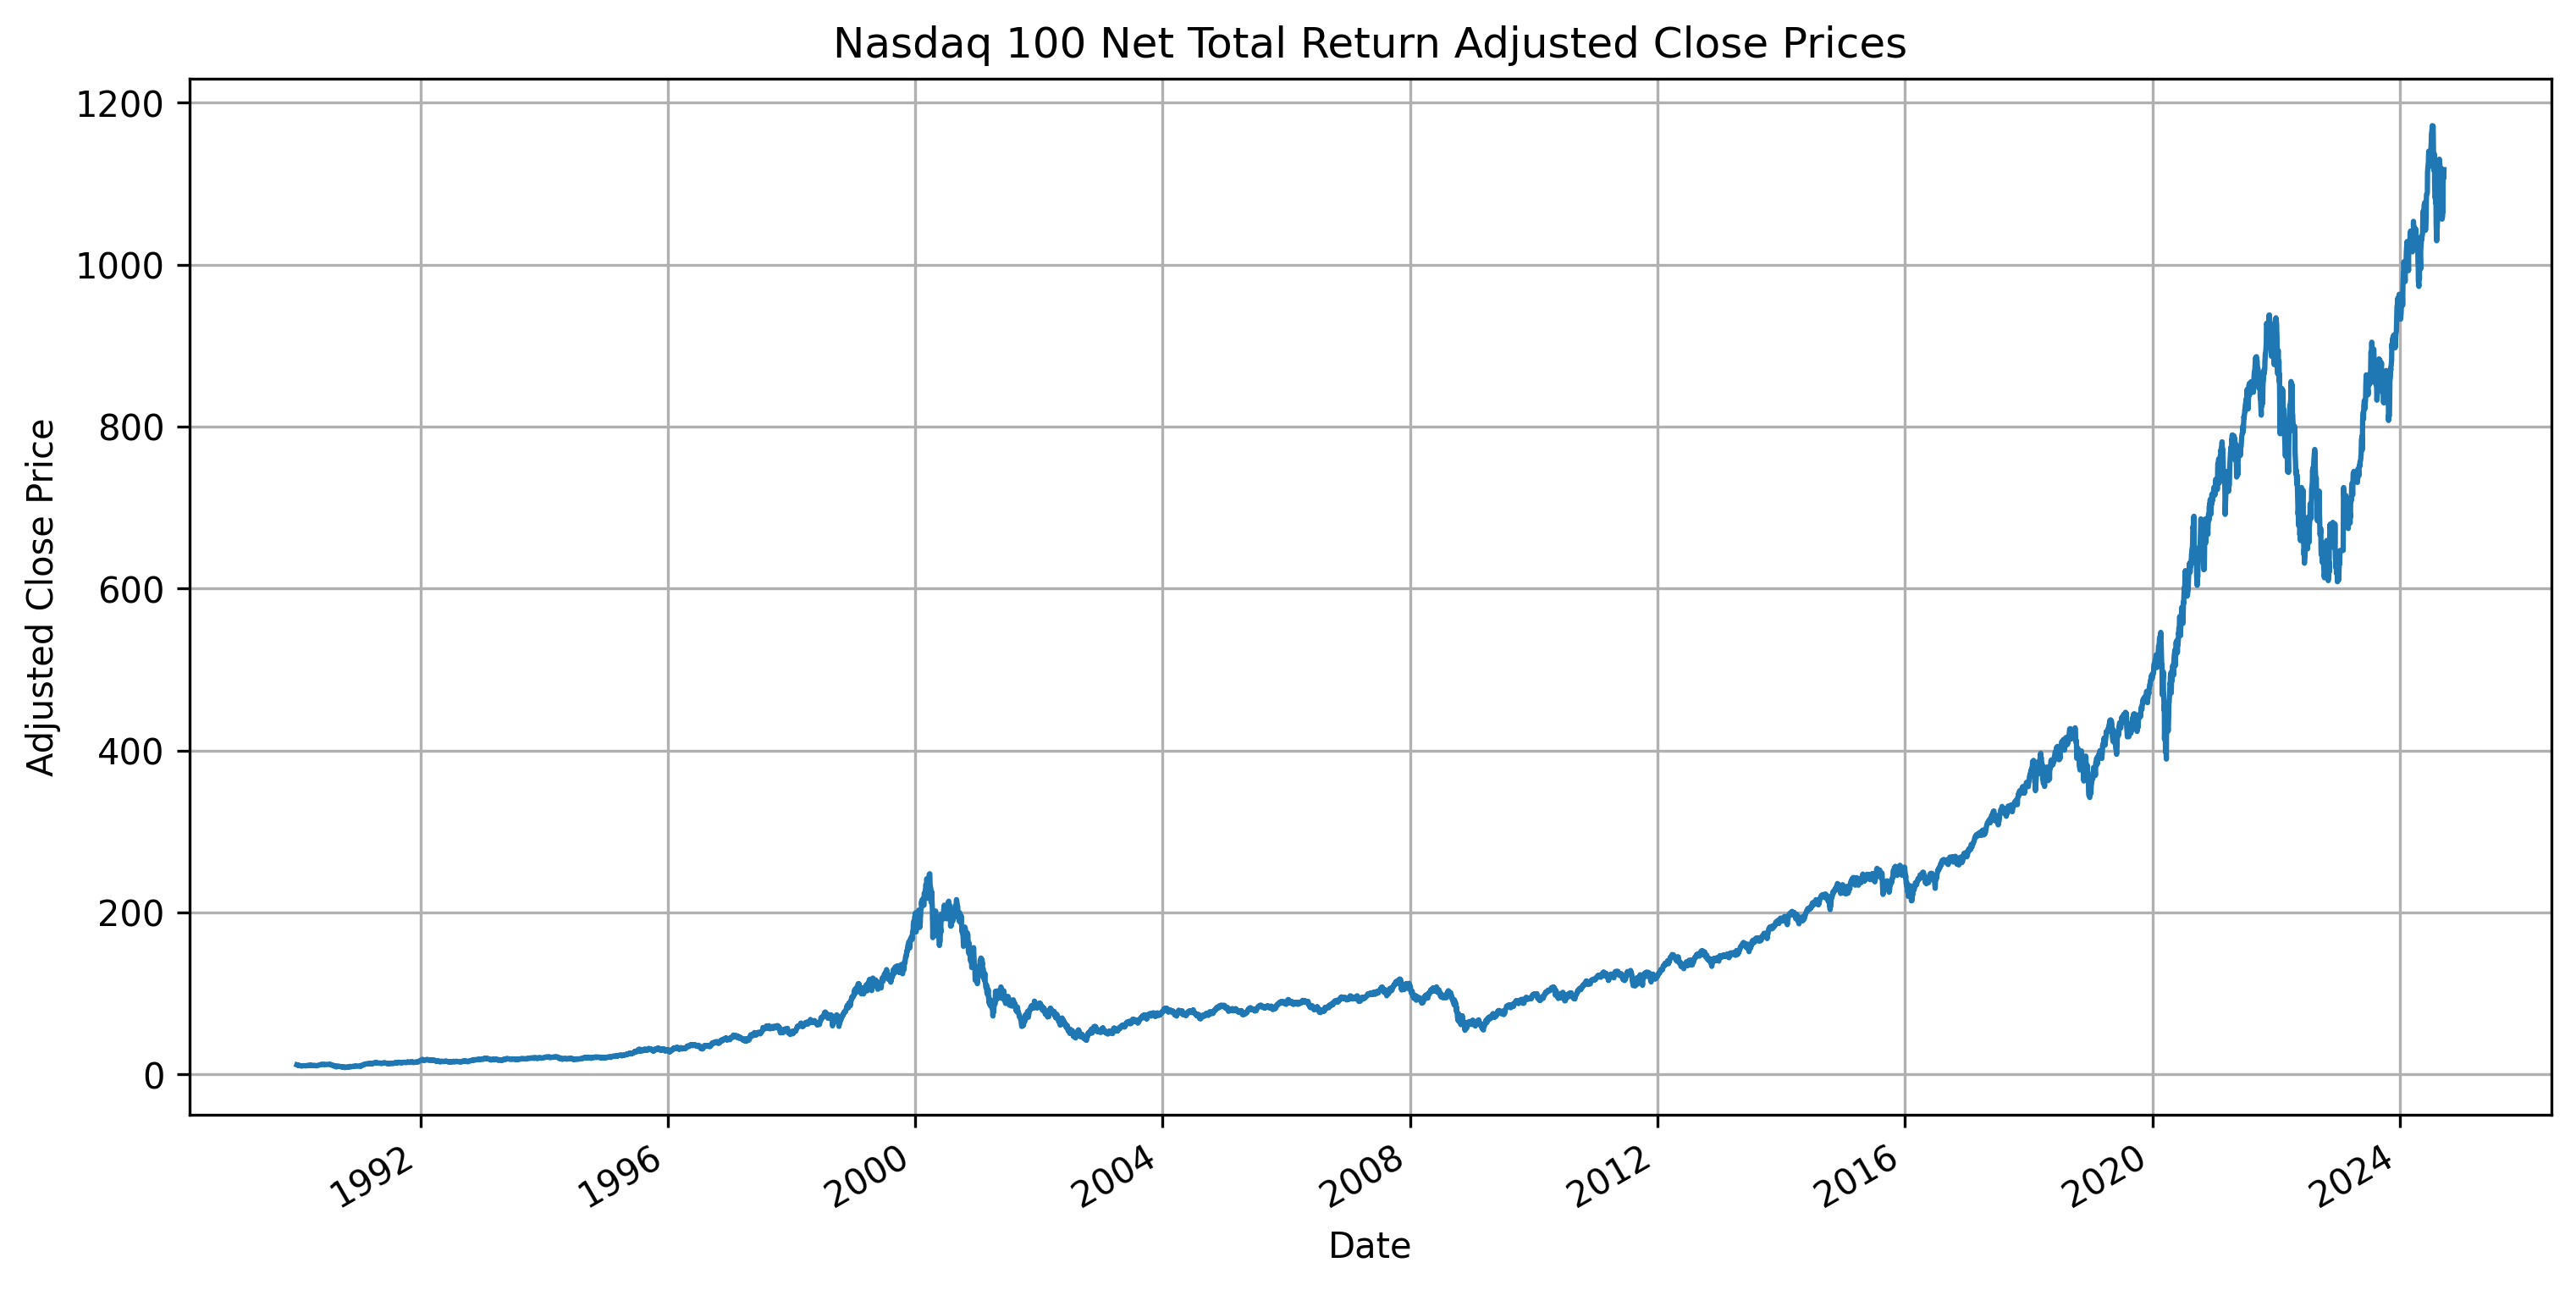

In [3]:
# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Fetch data for ^NDX (NASDAQ-100 Index)
ndx_data = yf.download('^NDX', start='1990-01-01', end='2024-09-18')

# Fetch data for CSNDX.SW (ETF tracking NASDAQ-100 Net Total Return)
csndx_data = yf.download('CSNDX.SW', start='1990-01-01', end='2024-09-18')

# Check if data was fetched successfully
if ndx_data.empty or csndx_data.empty:
    print("Failed to fetch data for one or both tickers.")
else:
    # Get the first date where CSNDX.SW data is available
    first_csndx_date = csndx_data.first_valid_index()
    print(f"First available date for CSNDX.SW: {first_csndx_date.date()}")

    # Get NDX data up to the day before CSNDX.SW data starts
    ndx_data_trimmed = ndx_data.loc[ndx_data.index < first_csndx_date].copy()

    # Ensure there is overlapping data
    if ndx_data_trimmed.empty:
        print("No overlapping data found before CSNDX.SW starts.")
    else:
        # Get the last 'Adj Close' value of NDX before CSNDX.SW starts
        last_ndx_value = ndx_data_trimmed['Adj Close'].iloc[-1]

        # Get the first 'Adj Close' value of CSNDX.SW
        first_csndx_value = csndx_data['Adj Close'].iloc[0]

        # Calculate scaling factor to align the two datasets
        scaling_factor = first_csndx_value / last_ndx_value

        # Scale NDX 'Adj Close' to match CSNDX.SW
        ndx_data_trimmed['Adj Close'] = ndx_data_trimmed['Adj Close'] * scaling_factor

        # Extract 'Adj Close' columns
        ndx_adj_close = ndx_data_trimmed['Adj Close']
        csndx_adj_close = csndx_data['Adj Close']

        # Concatenate the two series
        nasdaq = pd.concat([ndx_adj_close, csndx_adj_close])

        # Plot the combined data
        plt.figure(figsize=(12, 6), dpi=300)
        nasdaq.plot(title='Nasdaq 100 Net Total Return Adjusted Close Prices')
        plt.xlabel('Date')
        plt.ylabel('Adjusted Close Price')
        plt.grid(True)
        plt.show()

        # Optional: Save the combined data to a CSV file
        nasdaq.to_csv('combined_ndx_csndx.csv', header=['Adjusted Close'])

In [4]:
em_data = pd.read_csv('data/msci_em_net_return.csv', index_col='Date', parse_dates=True)
print(em_data.head())

            Emerging Markets
Date                        
1999-01-29            98.493
1999-02-26            99.442
1999-03-31           112.582
1999-04-30           126.502
1999-05-31           125.771


[*********************100%***********************]  1 of 1 completed


First available date for XSX6.DE: 2009-01-20


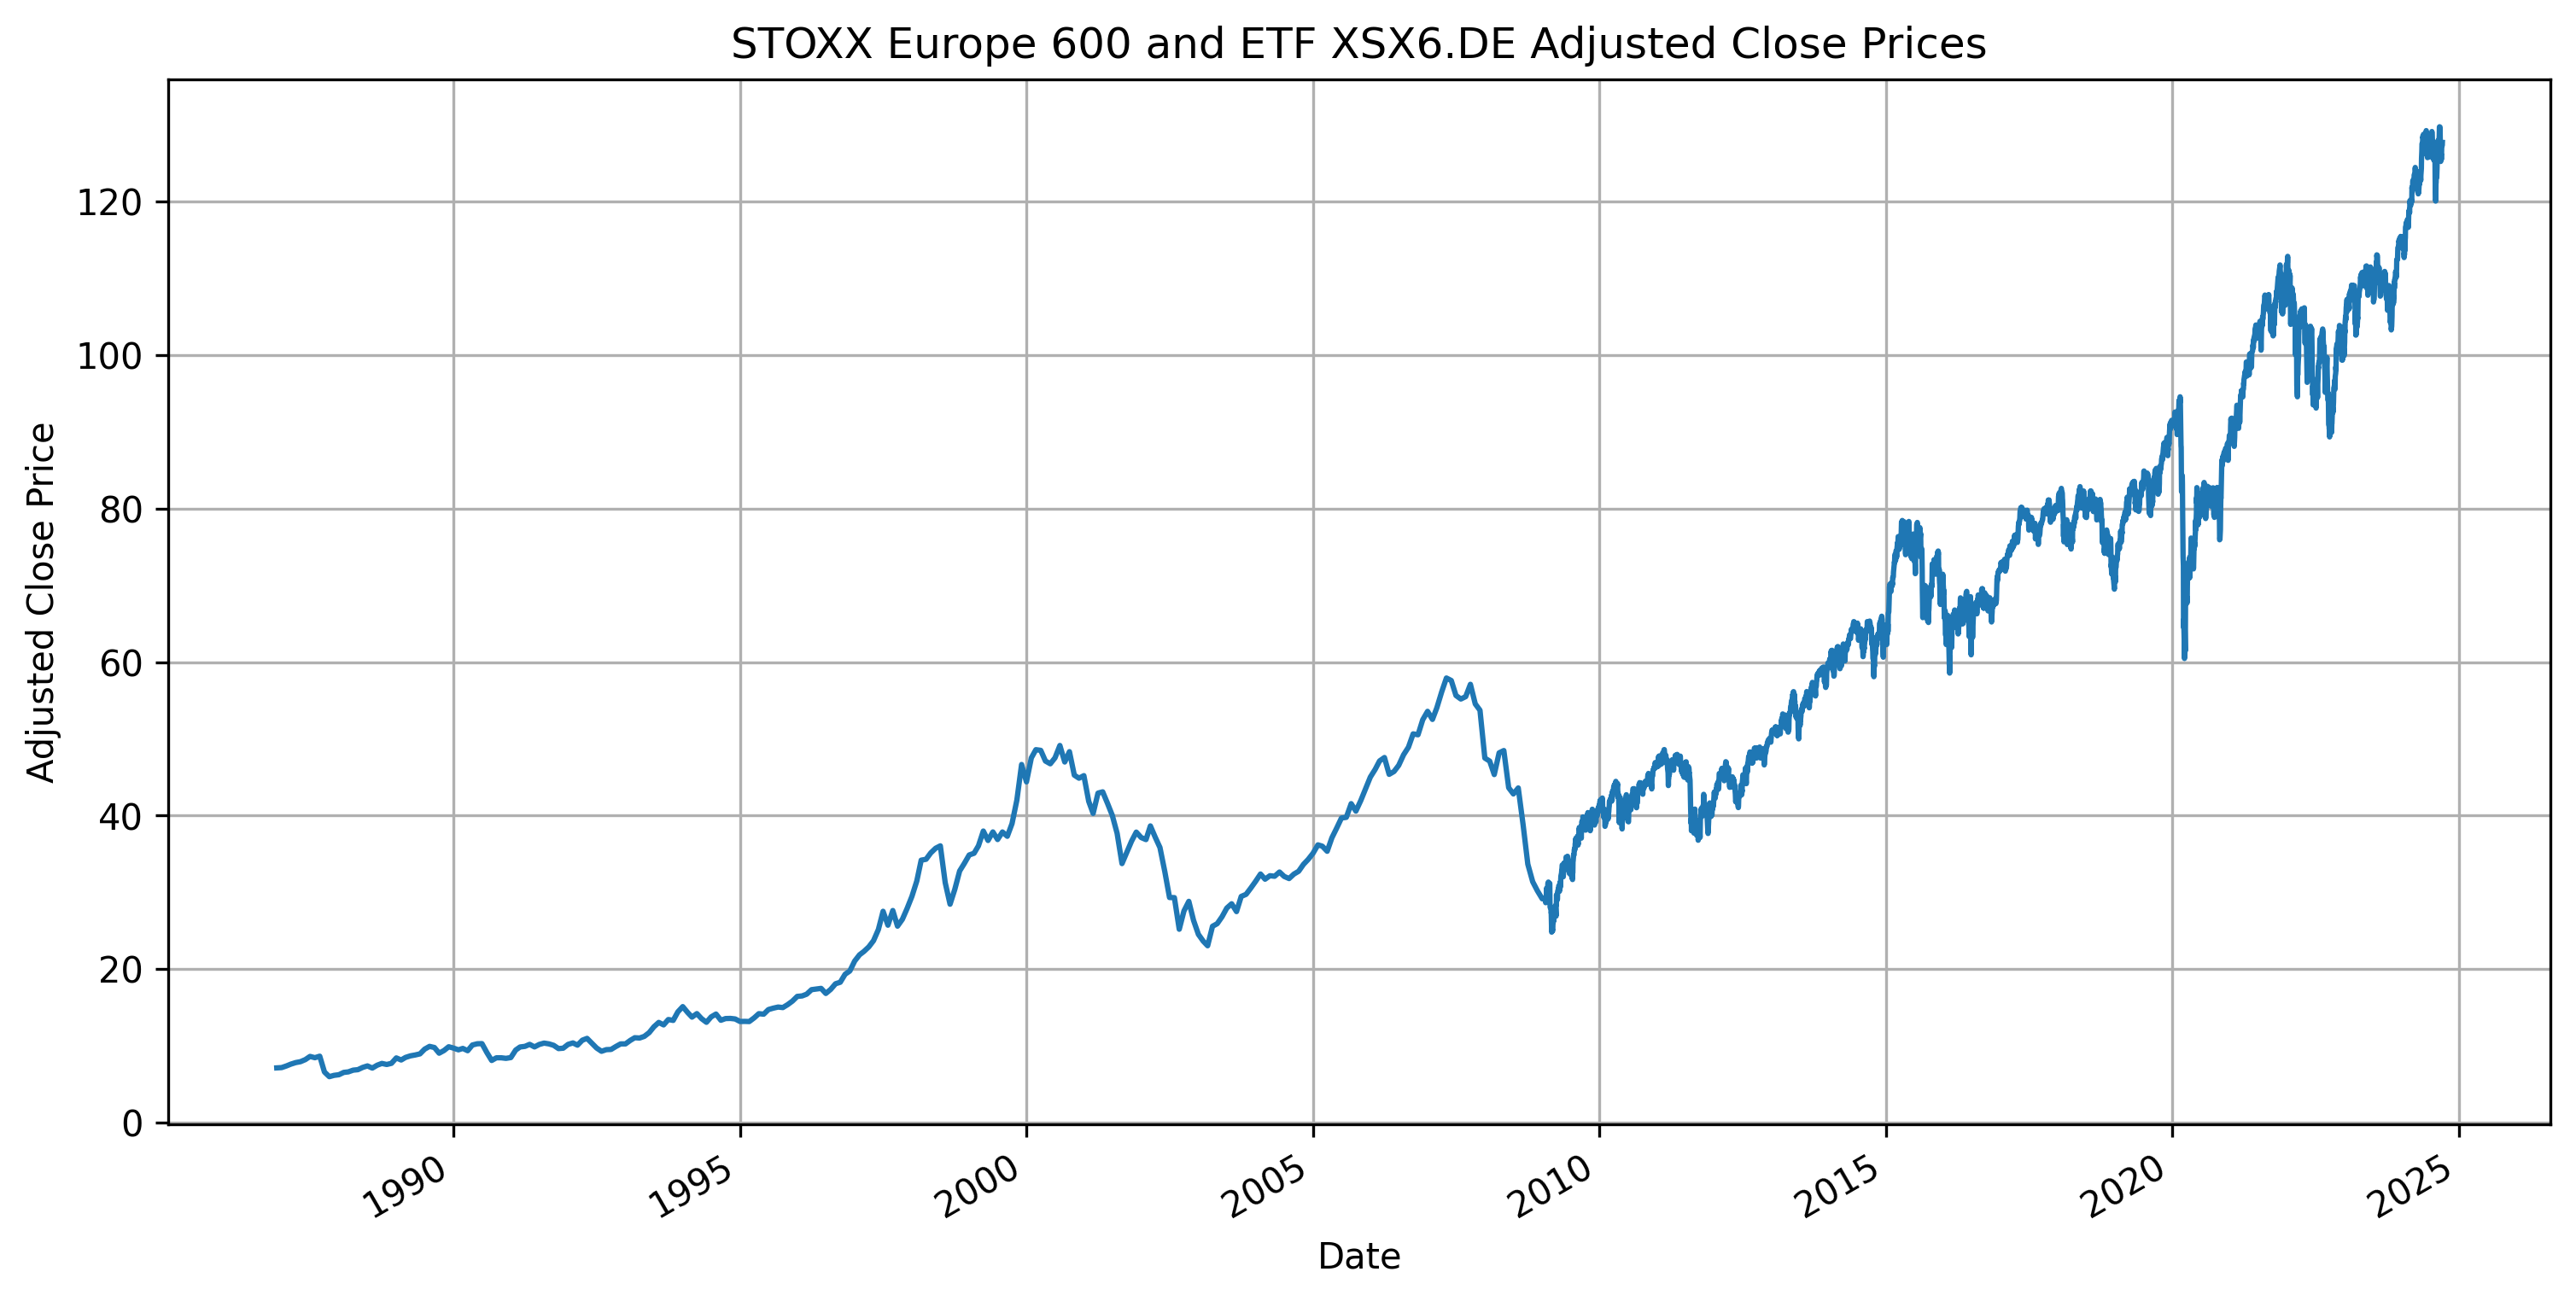

Data successfully concatenated and saved to 'combined_stoxx_etf.csv'


In [5]:
# Load your existing STOXX Europe 600 data
stoxx_data = pd.read_csv('data/stoxx600.csv')

# Fetch data for XSX6.DE (ETF tracking STOXX Europe 600)
etf_data = yf.download('XSX6.DE', start='1990-01-01', end='2024-09-18')

# Ensure that the 'Date' column in stoxx_data is a datetime object
stoxx_data['Date'] = pd.to_datetime(stoxx_data['Date'], format='%m/%Y')

# Check if data was fetched successfully
if etf_data.empty:
    print("Failed to fetch data for XSX6.DE.")
else:
    # Get the first date where XSX6.DE data is available
    first_etf_date = etf_data.first_valid_index()
    print(f"First available date for XSX6.DE: {first_etf_date.date()}")

    # Get STOXX data up to the day before XSX6.DE data starts
    stoxx_data_trimmed = stoxx_data[stoxx_data['Date'] < first_etf_date].copy()

    # Ensure there is overlapping data
    if stoxx_data_trimmed.empty:
        print("No overlapping data found before XSX6.DE starts.")
    else:
        # Get the last 'STOXX Europe 600' value of STOXX before XSX6.DE starts
        last_stoxx_value = stoxx_data_trimmed['STOXX Europe 600'].iloc[-1]

        # Get the first 'Adj Close' value of XSX6.DE
        first_etf_value = etf_data['Adj Close'].iloc[0]

        # Calculate scaling factor to align the two datasets
        scaling_factor = first_etf_value / last_stoxx_value

        # Scale STOXX Europe 600 data to match XSX6.DE
        stoxx_data_trimmed['STOXX Europe 600'] = stoxx_data_trimmed['STOXX Europe 600'] * scaling_factor

        # Extract 'STOXX Europe 600' and 'Adj Close' columns
        stoxx_adj_close = stoxx_data_trimmed.set_index('Date')['STOXX Europe 600']
        etf_adj_close = etf_data['Adj Close']

        # Concatenate the two series
        stoxx600 = pd.concat([stoxx_adj_close, etf_adj_close])

        # Plot the combined data
        plt.figure(figsize=(12, 6), dpi=300)
        stoxx600.plot(title='STOXX Europe 600 and ETF XSX6.DE Adjusted Close Prices')
        plt.xlabel('Date')
        plt.ylabel('Adjusted Close Price')
        plt.grid(True)
        plt.show()

        # Optional: Save the combined data to a CSV file
        stoxx600.to_csv('combined_stoxx_etf.csv', header=['Adjusted Close'])

        print("Data successfully concatenated and saved to 'combined_stoxx_etf.csv'")

In [6]:
# Spot Price Gold Price (GLD)
gold_spot = pd.read_csv('data/gold_prices.csv', index_col='Date', parse_dates=True)

In [7]:
msci_world_data = pd.read_csv('data/msci_world_net_return.csv', index_col='Date', parse_dates=True)

# Step 1: Resample the data to monthly frequency
msci_world_monthly = msci_world_data['MSCI World Net Return'].resample('M').last()

# Step 2: Compute the monthly percentage returns
msci_world_returns = msci_world_monthly.pct_change().dropna()

# Step 3: Compute the cumulative returns
msci_world_cumulative_returns = (1 + msci_world_returns).cumprod()

# Optional: Print the first few rows of the cumulative returns
print(msci_world_cumulative_returns.head())

Date
1999-02-28    0.973041
1999-03-31    1.014248
1999-04-30    1.054026
1999-05-31    1.016119
1999-06-30    1.063720
Freq: ME, Name: MSCI World Net Return, dtype: float64


Columns in returns_df: ['SP500', 'Nasdaq', 'Emerging Markets', 'Stoxx600', 'Gold']


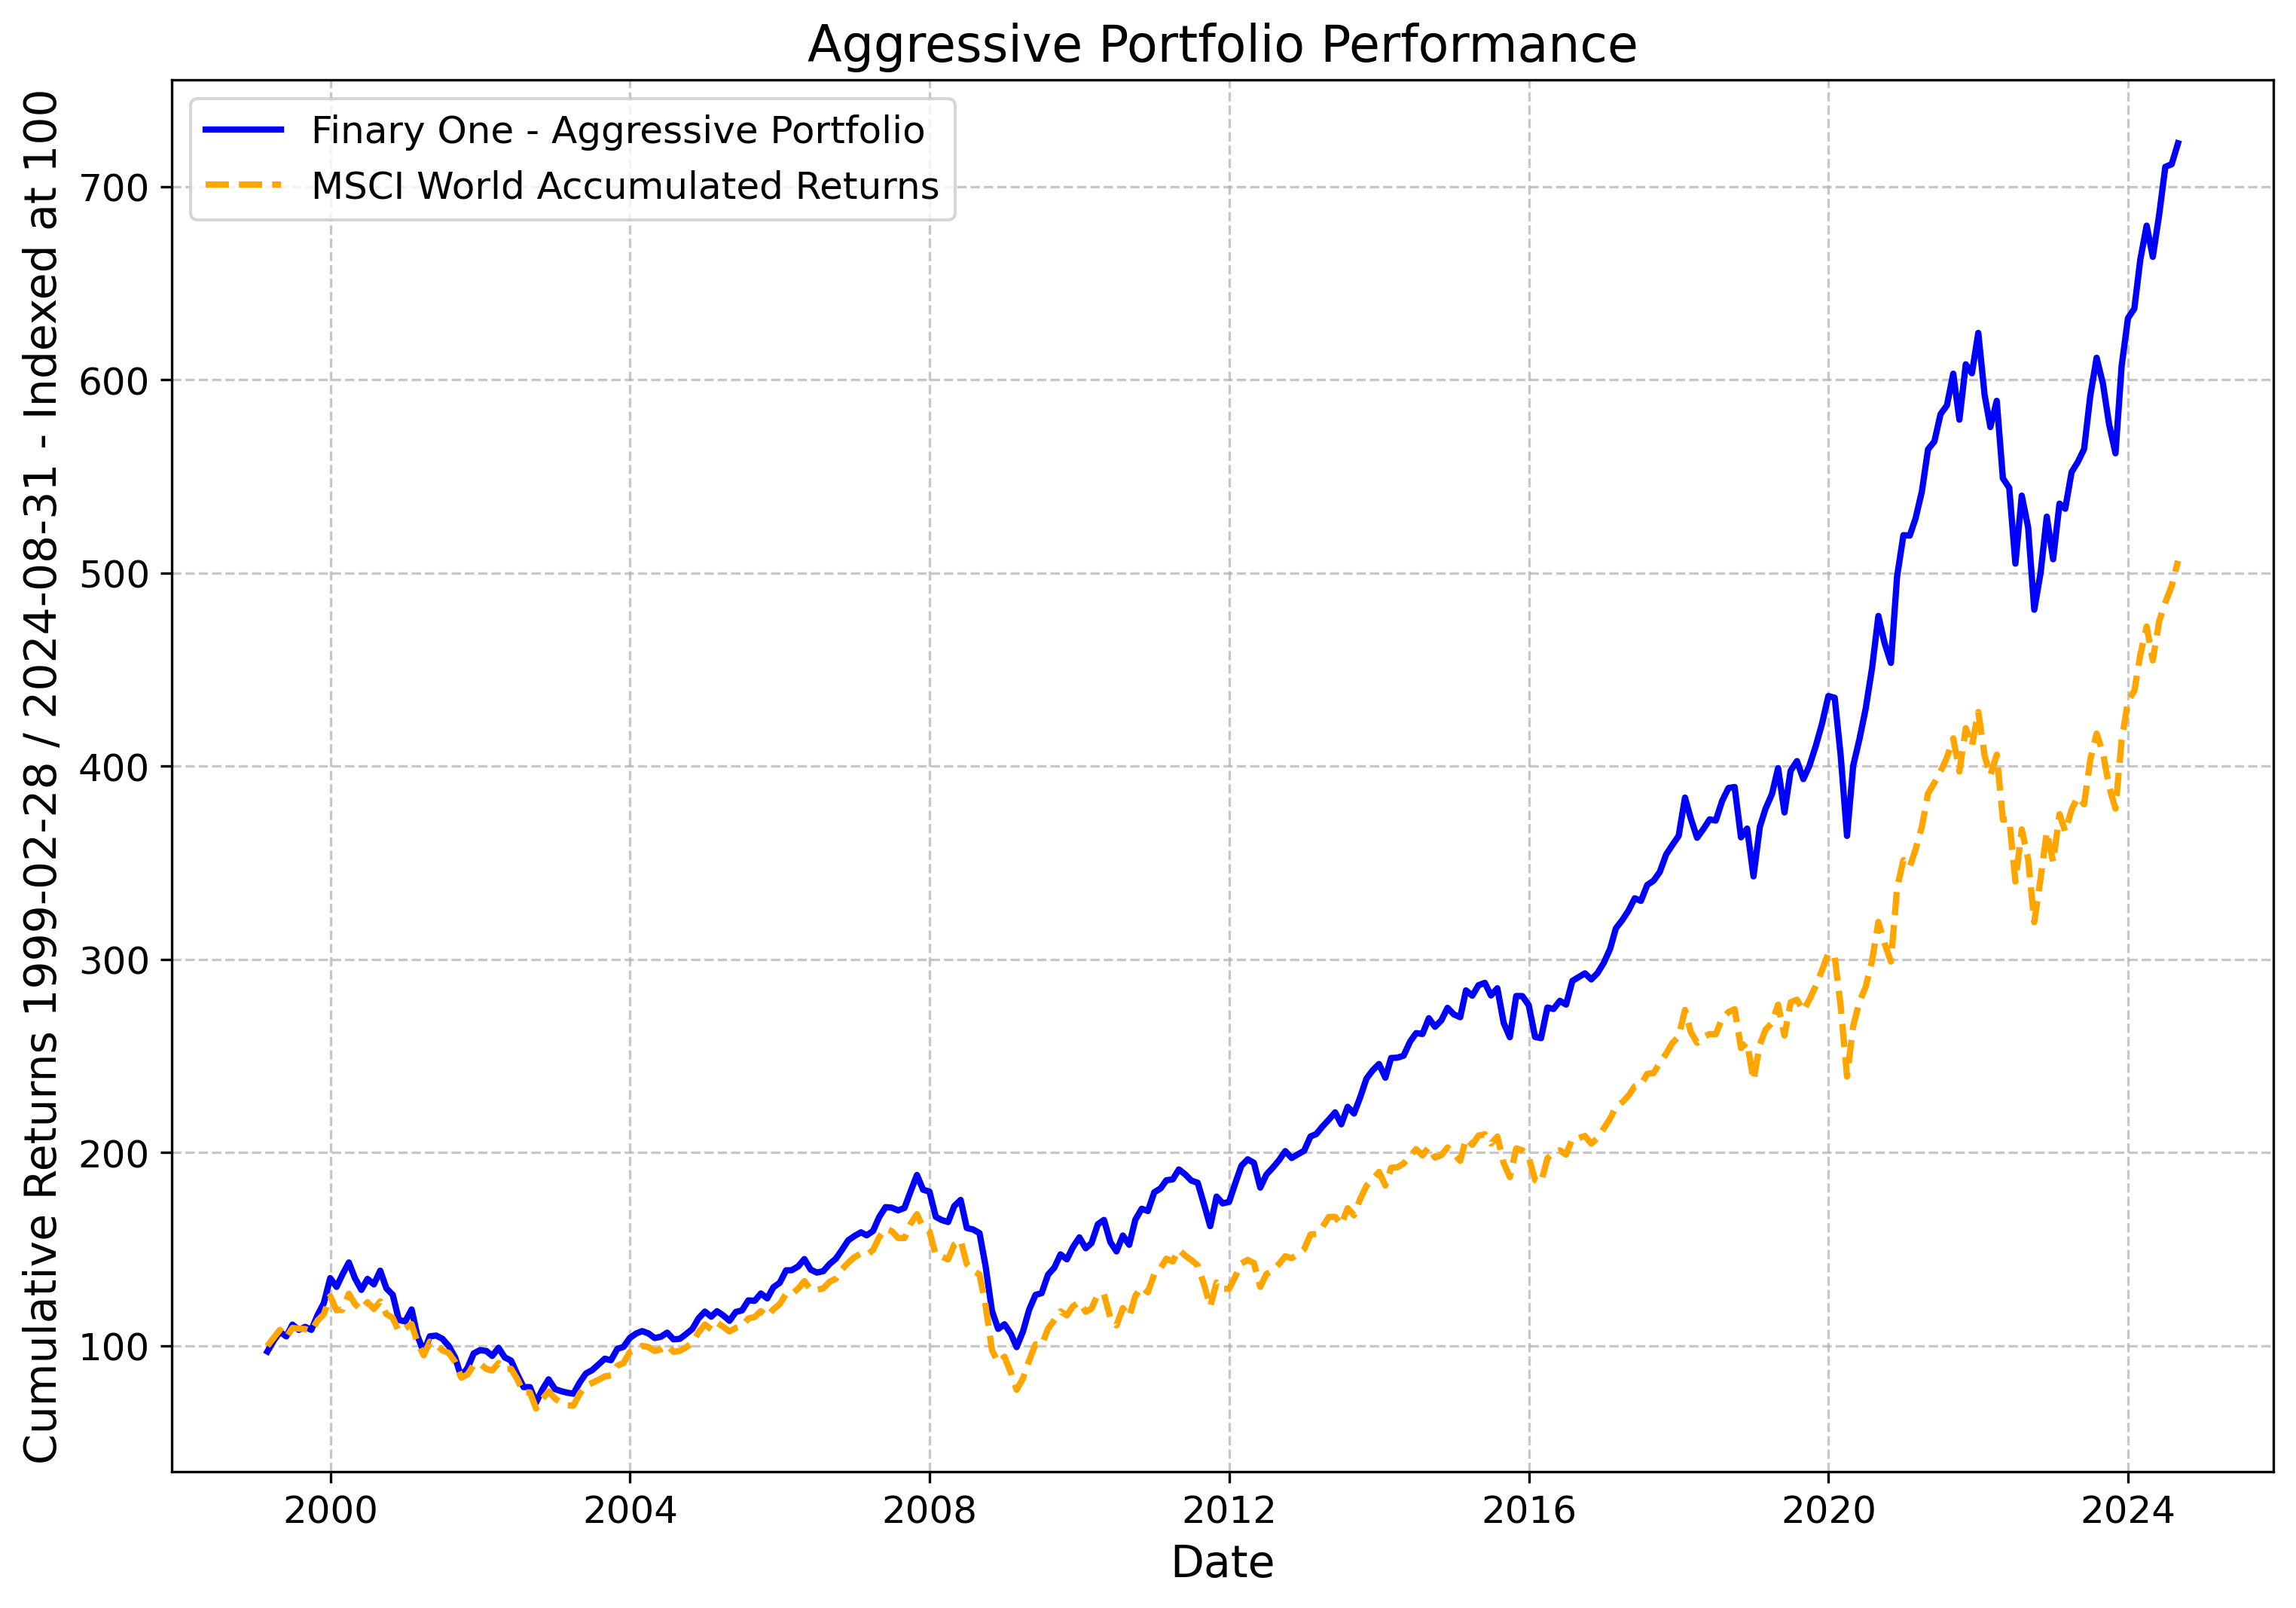

In [8]:
# Step 1: Extract the 'Adj Close' (or appropriate) column and resample to monthly data
sp_monthly = sp_data['Adj Close'].resample('M').last()
nasdaq_monthly = nasdaq.resample('M').last()
em_monthly = em_data.resample('M').last()
stoxx600_monthly = stoxx600.resample('M').last()
gold_monthly = gold_spot['Gold Price'].resample('M').last()

# Step 2: Compute monthly percentage returns and assign a name to each Series
sp_returns = sp_monthly.pct_change().dropna()
sp_returns.name = 'SP500'

nasdaq_returns = nasdaq_monthly.pct_change().dropna()
nasdaq_returns.name = 'Nasdaq'

em_returns = em_monthly.pct_change().dropna()
em_returns.name = 'MSCI_EM'

stoxx600_returns = stoxx600_monthly.pct_change().dropna()
stoxx600_returns.name = 'Stoxx600'

gold_returns = gold_monthly.pct_change().dropna()
gold_returns.name = 'Gold'

# Step 3: Combine the returns into a DataFrame
returns_df = pd.concat(
    [sp_returns, nasdaq_returns, em_returns, stoxx600_returns, gold_returns],
    axis=1
)

# Step 4: Drop rows with NaN values to align the dates
returns_df.dropna(inplace=True)

# Optional: Verify that the DataFrame now has 5 columns
print(f"Columns in returns_df: {returns_df.columns.tolist()}")  # Should list all 5 asset names

# Step 5: Define your portfolio weights
weights = [0.4, 0.2, 0.15, 0.15, 0.1]

# Ensure weights sum to 1 (optional if weights are already normalized)
weights = [w / sum(weights) for w in weights]

# Step 6: Compute the portfolio returns
portfolio_returns = returns_df.dot(weights)

# Step 7: Index cumulative returns to 100 instead of 1
cumulative_returns_indexed = 100 * (1 + portfolio_returns).cumprod()
msci_world_cumulative_returns_indexed = 100 * msci_world_cumulative_returns / msci_world_cumulative_returns.iloc[0]

# Step 8: Save everything in a variable called aggressive_portfolio
cumulative_returns_indexed.index = pd.to_datetime(cumulative_returns_indexed.index)

aggressive_portfolio = pd.DataFrame({
    'Portfolio_Returns': portfolio_returns,
    'Cumulative_Returns': cumulative_returns_indexed
})

# Step 9: Plot the performance, indexed at 100
plt.figure(figsize=(12, 8), dpi=300)
plt.plot(cumulative_returns_indexed, label='Finary One - Aggressive Portfolio', color='blue', linewidth=2)
plt.plot(msci_world_cumulative_returns_indexed, label='MSCI World Accumulated Returns', color='orange', linestyle='--', linewidth=2)
plt.title('Aggressive Portfolio Performance', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns 1999-02-28 / 2024-08-31 - Indexed at 100', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [9]:
global_stats1 = ffn.calc_stats(cumulative_returns_indexed)
global_stats1.set_riskfree_rate(0.005)
global_stats1.display()

Stats for None from 1999-02-28 00:00:00 - 2024-08-31 00:00:00
Annual risk-free rate considered: 0.50%
Summary:
Total Return    Sharpe    CAGR    Max Drawdown
--------------  --------  ------  --------------
644.05%         -         8.19%   -50.62%

Annualized Returns:
mtd    3m     6m     ytd     1y      3y     5y      10y     incep.
-----  -----  -----  ------  ------  -----  ------  ------  --------
1.53%  5.40%  9.09%  14.32%  20.82%  6.20%  12.92%  10.36%  8.19%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  -        0.58       0.44
mean    -        8.99%      8.69%
vol     -        14.73%     18.76%
skew    -        -0.58      -0.77
kurt    -        0.83       0.28
best    -        10.57%     40.47%
worst   -        -16.34%    -38.18%

Drawdowns:
max      avg       # days
-------  ------  --------
-50.62%  -7.43%    206.25

Misc:
---------------  ------
avg. up month    3.37%
avg. down month  -3.43%
up year %        72.00%
12m up %     

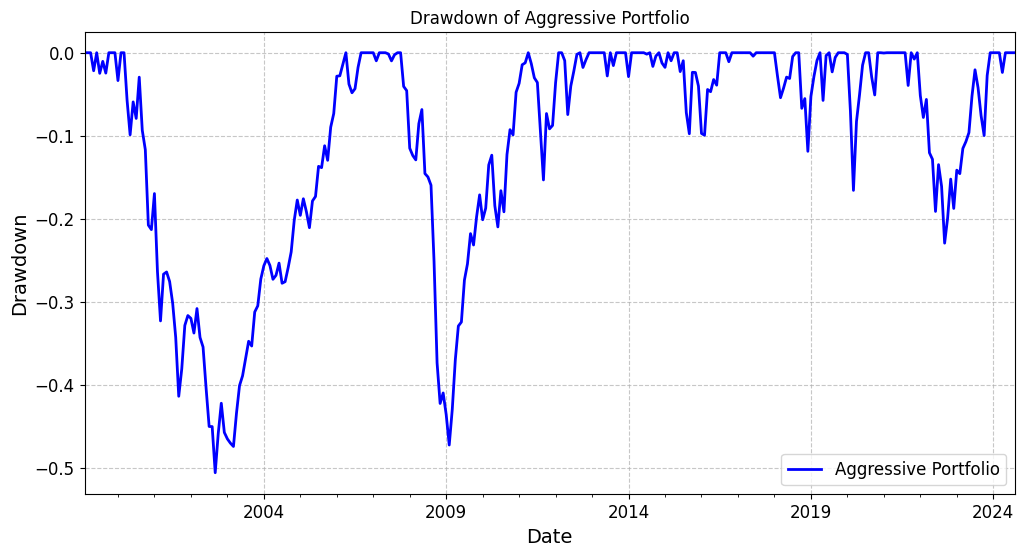

In [10]:
# Plot the drawdown series for the aggressive portfolio
drawdown1 = global_stats1.prices.to_drawdown_series().plot(
    figsize=(12, 6),
    grid=True, 
    title='Drawdown of Aggressive Portfolio', 
    color='blue', 
    linewidth=2,
)

# Add labels and legend
plt.xlabel('Date', fontsize=14)
plt.ylabel('Drawdown', fontsize=14)
plt.legend(['Aggressive Portfolio'], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

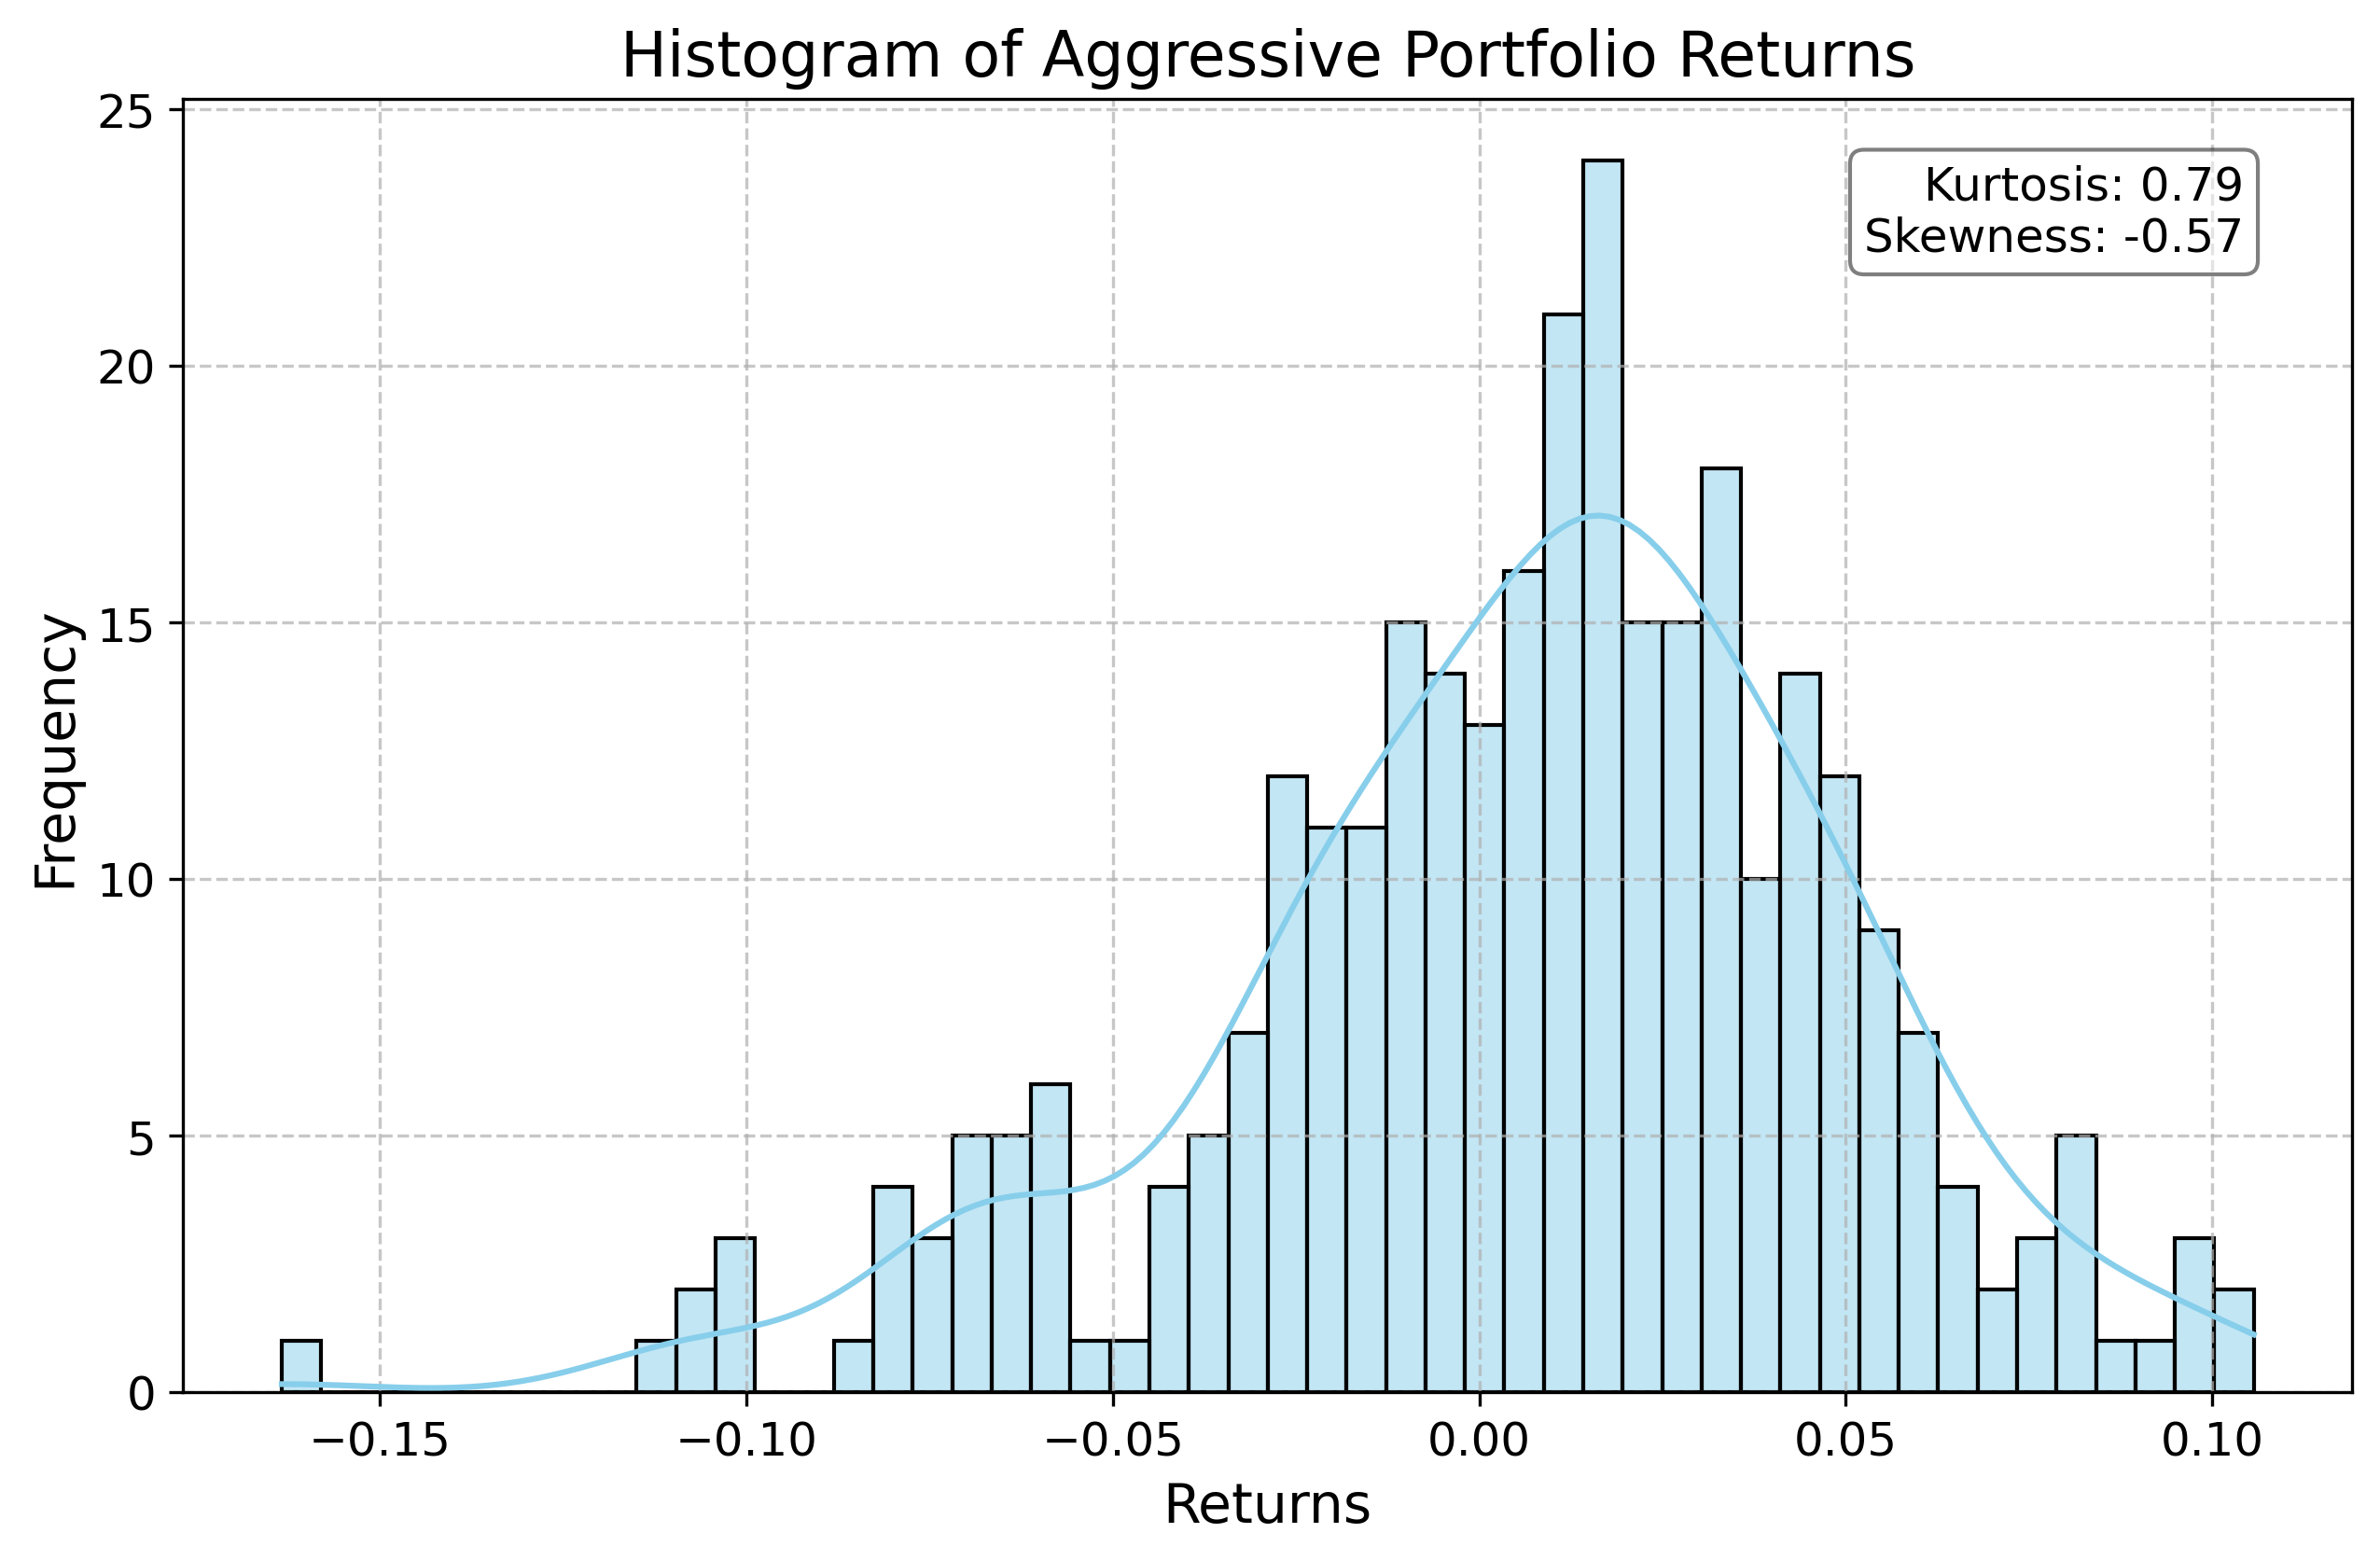

In [11]:
# Plot the histogram
plt.figure(figsize=(10, 6),  dpi=300)
sns.histplot(portfolio_returns, bins=50, kde=True, color='skyblue', edgecolor='black')

# Calculate kurtosis and skewness
kurt = kurtosis(portfolio_returns)
skewness = skew(portfolio_returns)

# Add text box with kurtosis and skewness
textstr = f'Kurtosis: {kurt:.2f}\nSkewness: {skewness:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.gca().text(0.95, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', horizontalalignment='right', bbox=props)

# Add labels and title
plt.title('Histogram of Aggressive Portfolio Returns', fontsize=16)
plt.xlabel('Returns', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

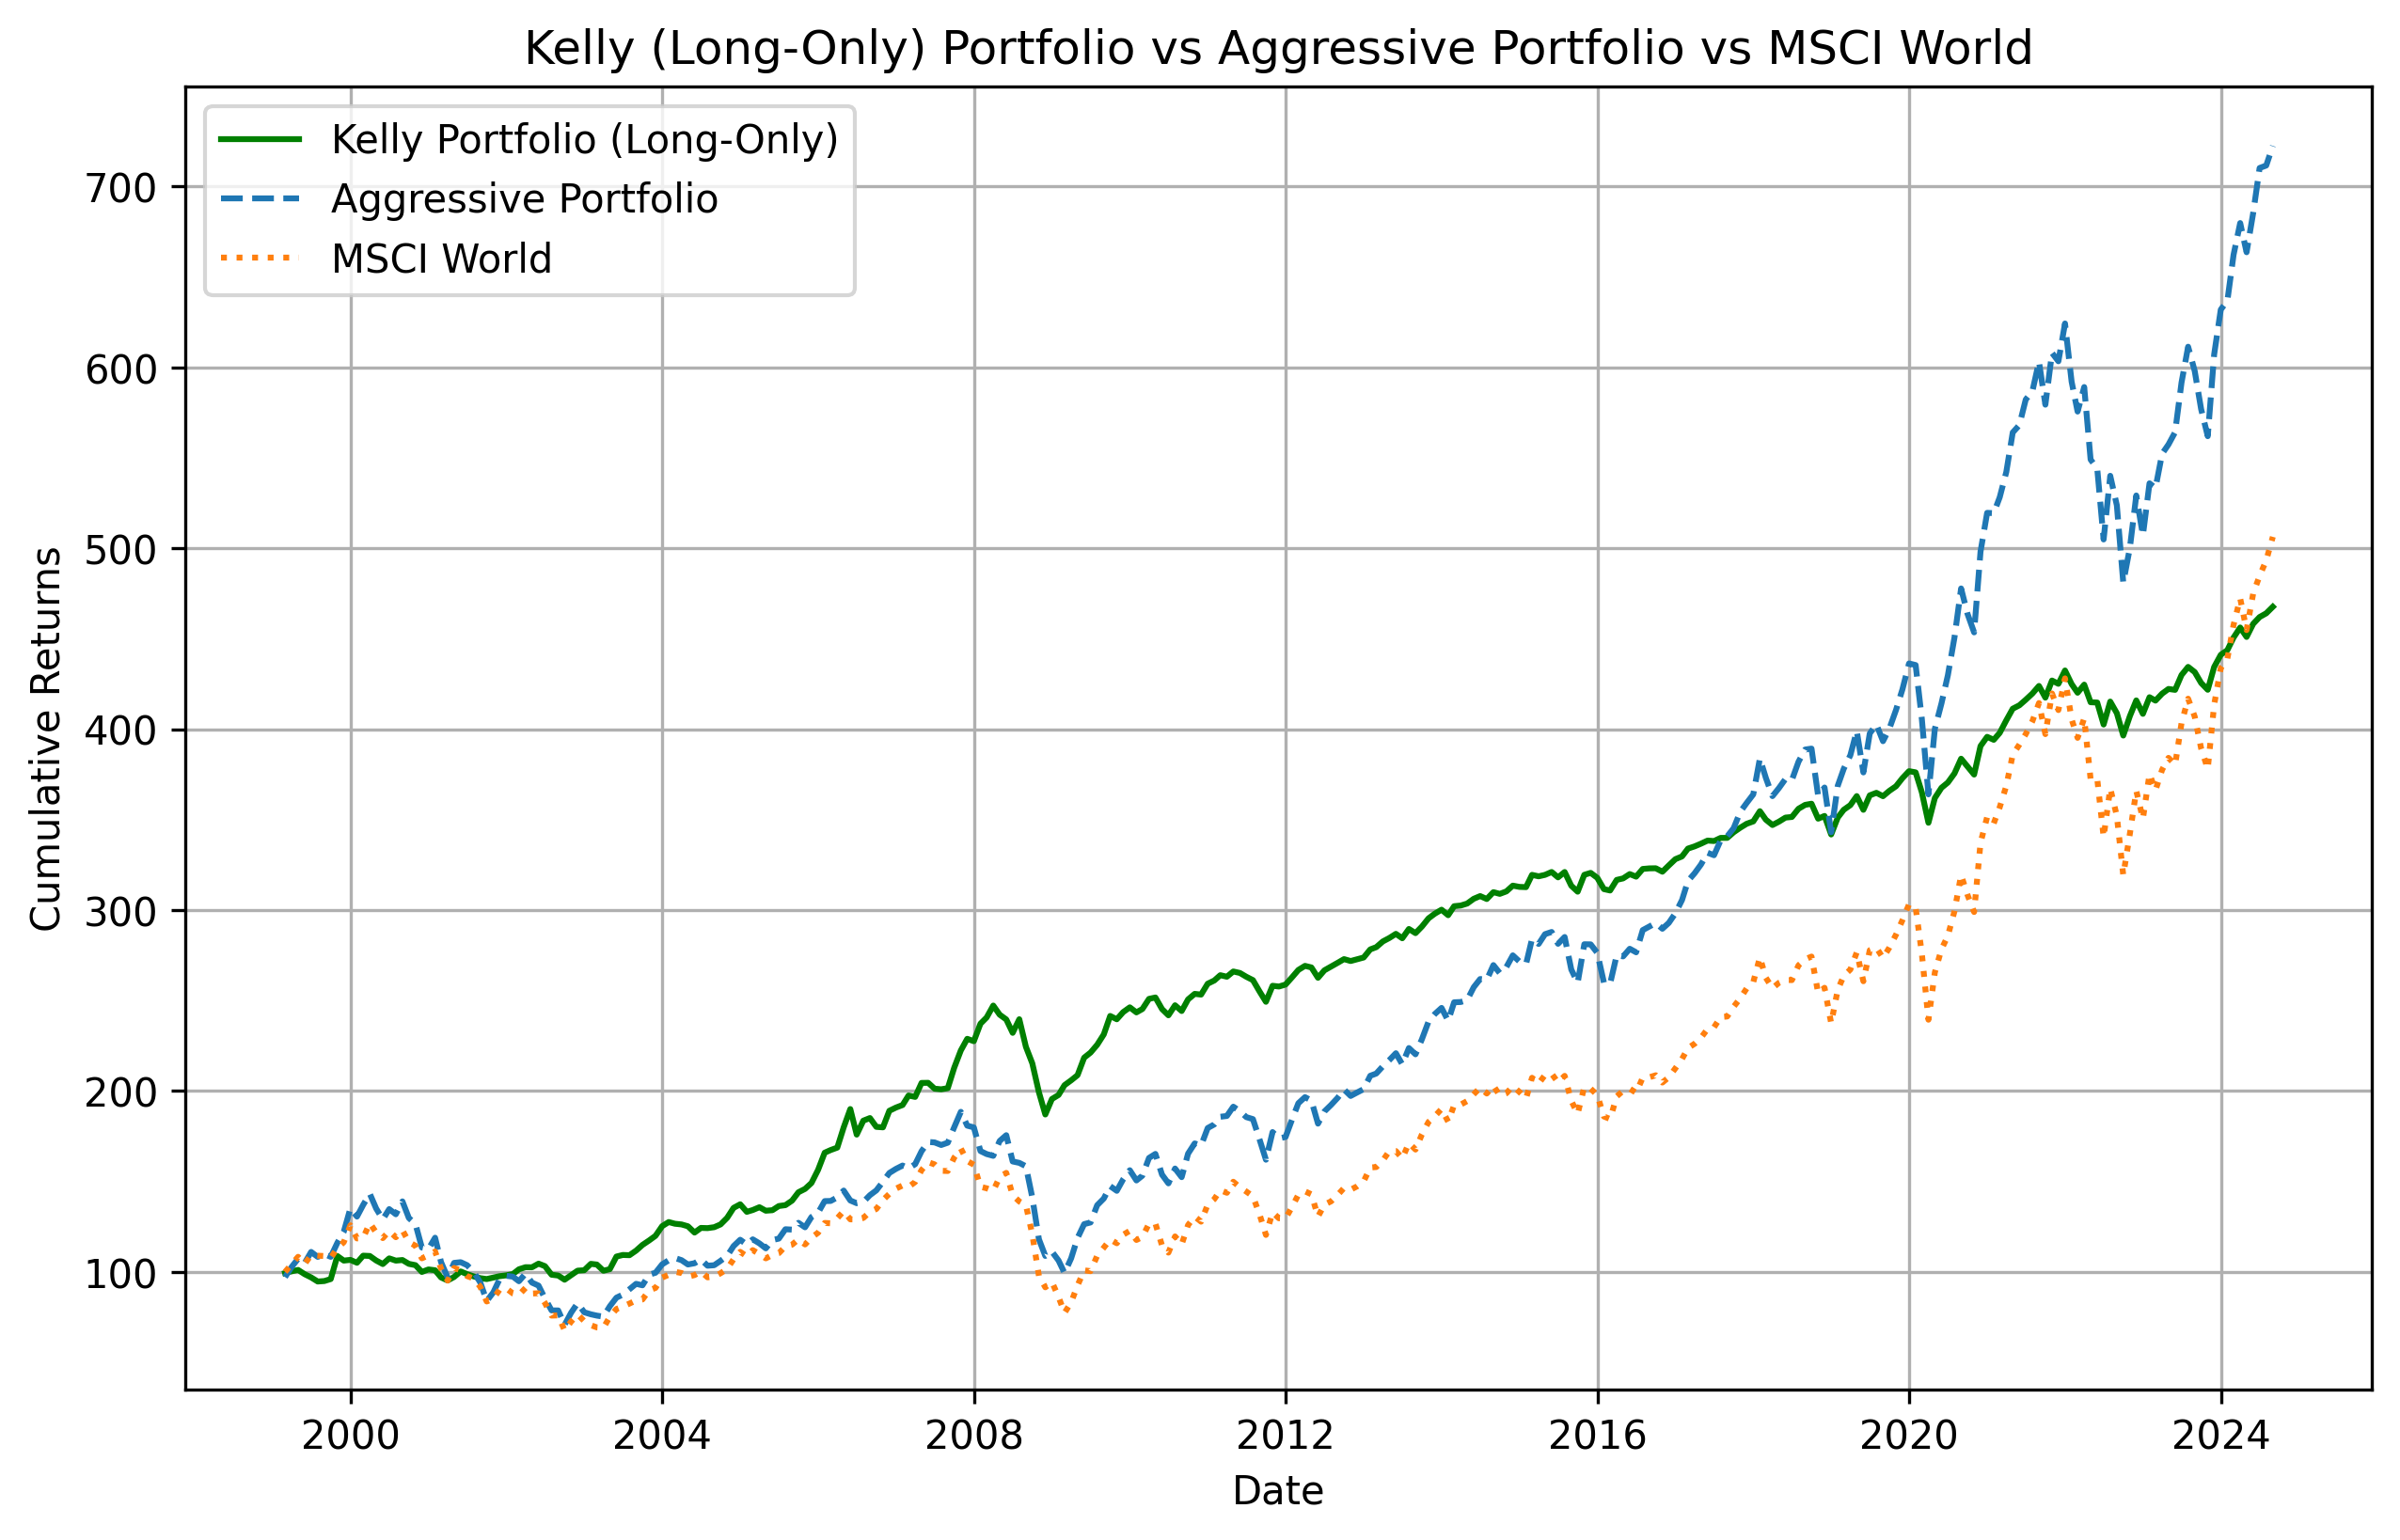

,Asset,Kelly Weights (Long-Only)
0,SP500,2.578209e-01
1,Nasdaq,2.753239e-16
2,Emerging Markets,0.000000e+00
3,Stoxx600,9.786881e-02
4,Gold,6.443103e-01


In [12]:
from scipy.optimize import minimize

expected_returns = returns_df.mean()  # Use the mean returns of individual assets
cov_matrix = returns_df.cov()  # Covariance matrix of the asset returns

# Step 1: Define the objective function (negative Kelly's criterion to minimize)
def kelly_criterion(weights, expected_returns, cov_matrix):
    # Negative of Kelly formula (since we are minimizing)
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return -portfolio_return / portfolio_variance

# Step 2: Define constraints and bounds (no shorting or leverage)
num_assets = len(expected_returns)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Weights sum to 1
bounds = tuple((0, 1) for _ in range(num_assets))  # No shorting, weights between 0 and 1

# Step 3: Initial guess for weights (equal weight allocation)
initial_weights = num_assets * [1. / num_assets]

# Step 4: Optimize using scipy's minimize function
result = minimize(kelly_criterion, initial_weights, args=(expected_returns, cov_matrix),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Step 5: Get the optimized Kelly weights
kelly_weights_long_only = result.x

# Step 6: Compute the Kelly portfolio returns using the optimized weights
kelly_portfolio_returns_long_only = returns_df.dot(kelly_weights_long_only)

# Step 7: Compute cumulative returns for the long-only Kelly portfolio
kelly_cumulative_returns_long_only = (1 + kelly_portfolio_returns_long_only).cumprod() * 100

# Step 8: Plot the performance of the long-only Kelly portfolio and compare it with the aggressive portfolio and MSCI World
plt.figure(figsize=(10, 6), dpi=300)

# Plot long-only Kelly portfolio cumulative returns
plt.plot(kelly_cumulative_returns_long_only, label='Kelly Portfolio (Long-Only)', color='green')

# Plot aggressive portfolio cumulative returns
plt.plot(cumulative_returns_indexed, label='Aggressive Portfolio', linestyle='--')

# Plot MSCI World cumulative returns
plt.plot(msci_world_cumulative_returns_indexed, label='MSCI World', linestyle=':')

plt.title('Kelly (Long-Only) Portfolio vs Aggressive Portfolio vs MSCI World')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Display the optimized Kelly weights for each asset
kelly_weights_long_only_df = pd.DataFrame({
    'Asset': returns_df.columns,
    'Kelly Weights (Long-Only)': kelly_weights_long_only
})
kelly_weights_long_only_df

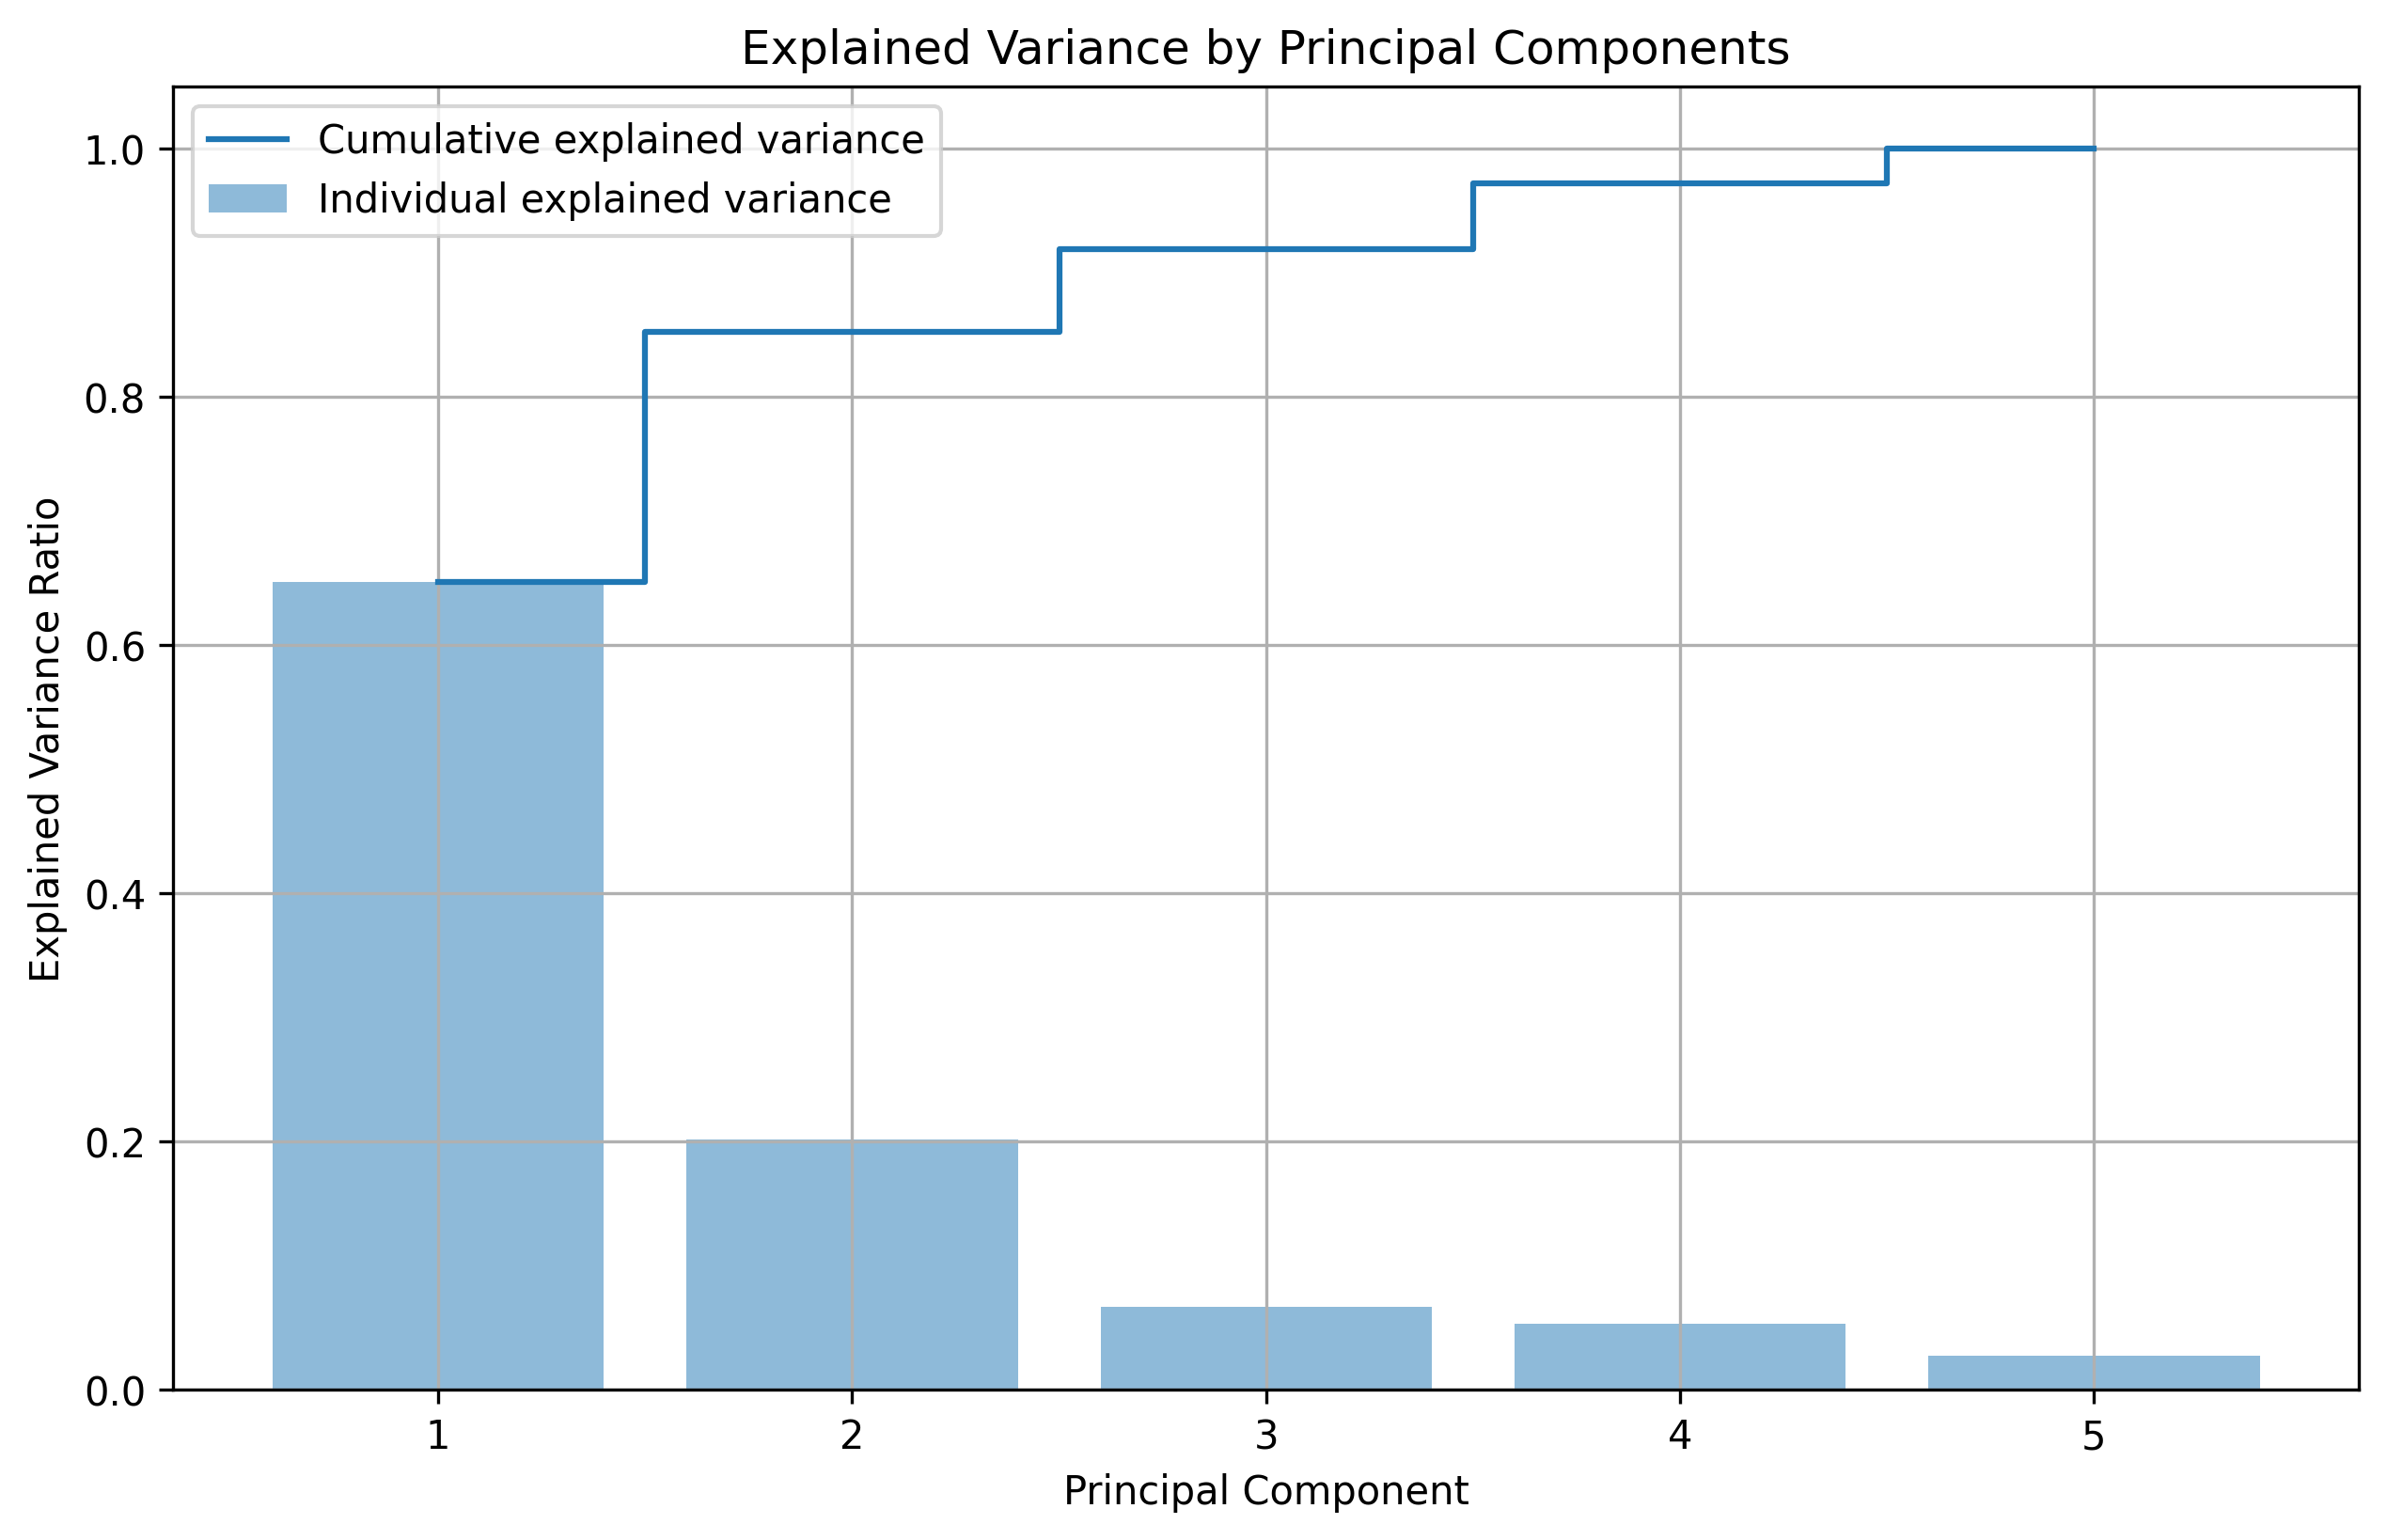

,SP500,Nasdaq,Emerging Markets,Stoxx600,Gold
PC1,0.523366,0.494217,0.471864,0.503450,-0.075628
PC2,0.011797,0.026682,0.178786,-0.058553,0.981711
PC3,-0.182185,-0.519124,0.818720,-0.089106,-0.138119
PC4,0.125748,-0.610207,-0.261619,0.729456,0.106227
PC5,0.822767,-0.336445,-0.081445,-0.450625,-0.012787


In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns_df)

# Step 2: Perform PCA
pca = PCA()
pca.fit(returns_scaled)

# Step 3: Get the explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_

# Step 4: Plot the explained variance
plt.figure(figsize=(10, 6), dpi=300)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid', label='Cumulative explained variance')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Step 5: Display the PCA components (principal axes in feature space)
pca_components = pd.DataFrame(pca.components_, columns=returns_df.columns, index=[f'PC{i+1}' for i in range(len(returns_df.columns))])
pca_components

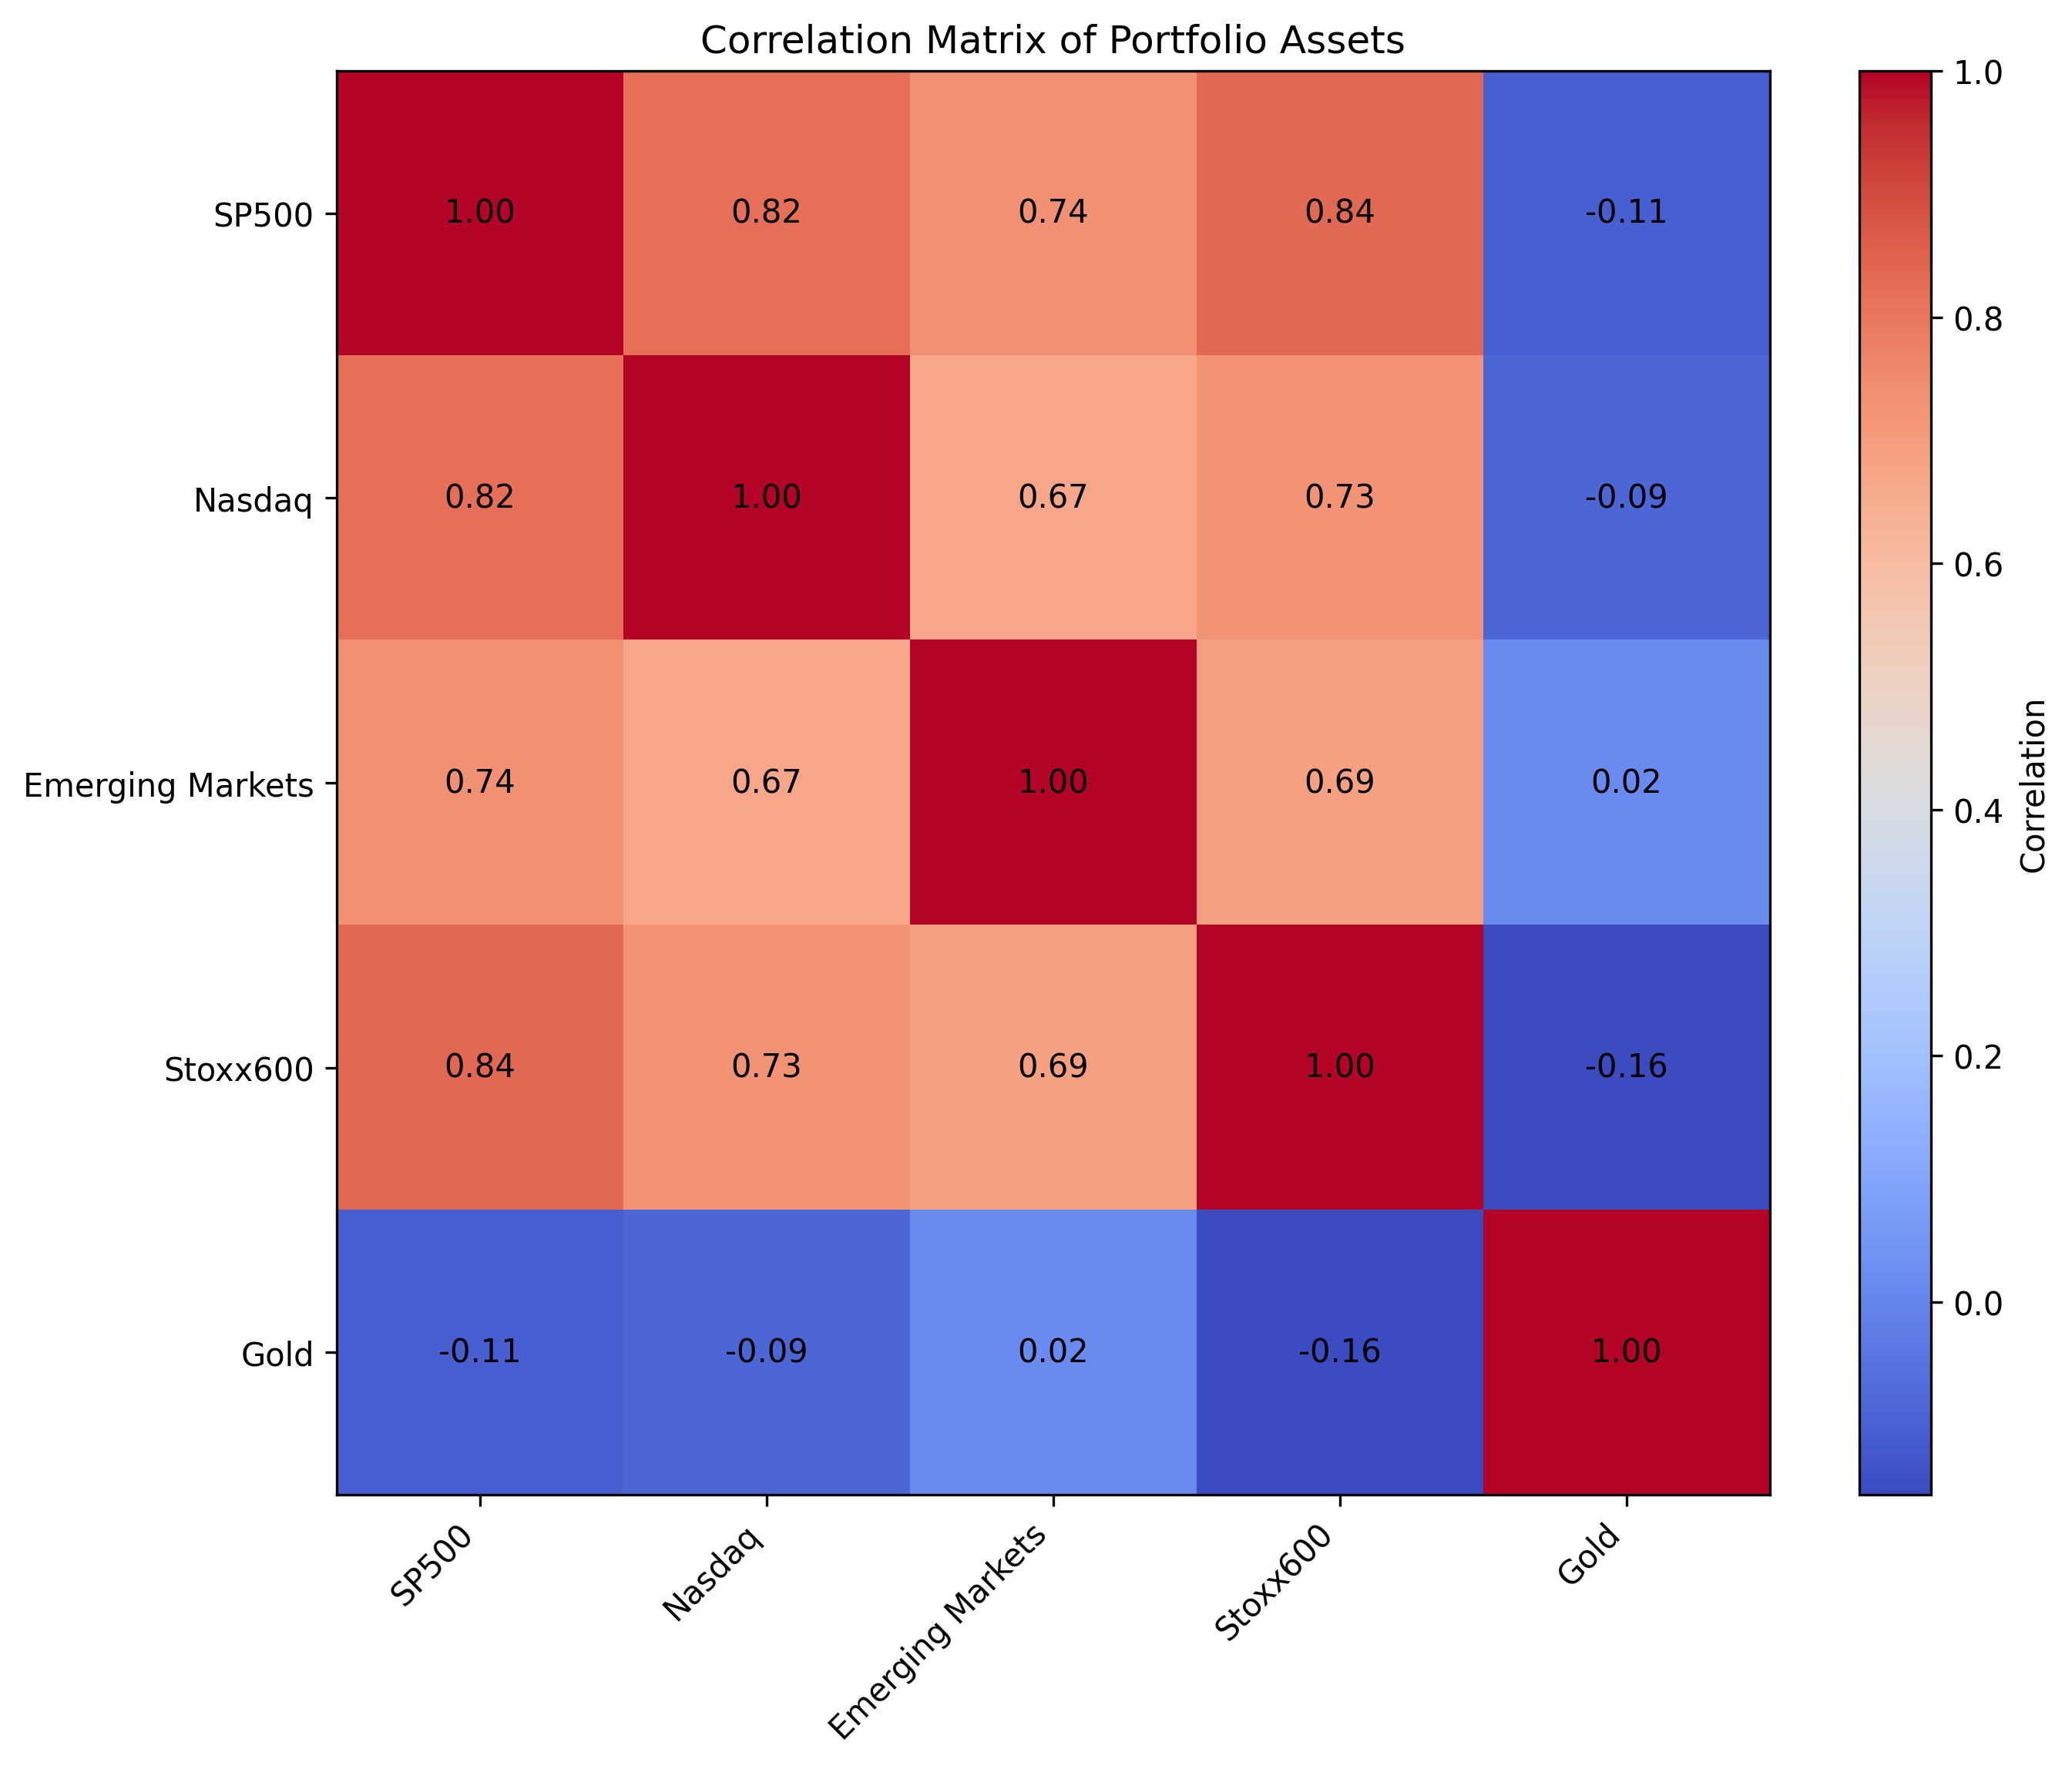

,SP500,Nasdaq,Emerging Markets,Stoxx600,Gold
SP500,1.000000,0.815024,0.737793,0.835275,-0.106594
Nasdaq,0.815024,1.000000,0.667552,0.726254,-0.087817
Emerging Markets,0.737793,0.667552,1.000000,0.692410,0.015845
Stoxx600,0.835275,0.726254,0.692410,1.000000,-0.156386
Gold,-0.106594,-0.087817,0.015845,-0.156386,1.000000


In [14]:
# Step 1: Compute the correlation matrix of the portfolio assets
correlation_matrix = returns_df.corr()

# Step 2: Plot the correlation matrix as a heatmap with numbers
plt.figure(figsize=(10, 8), dpi=300)
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar(label='Correlation')

# Add the correlation numbers on the heatmap
for (i, j), val in np.ndenumerate(correlation_matrix):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# Set x and y axis labels
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix of Portfolio Assets')
plt.grid(False)
plt.show()

# Step 3: Optionally, display the correlation matrix as a DataFrame
correlation_matrix


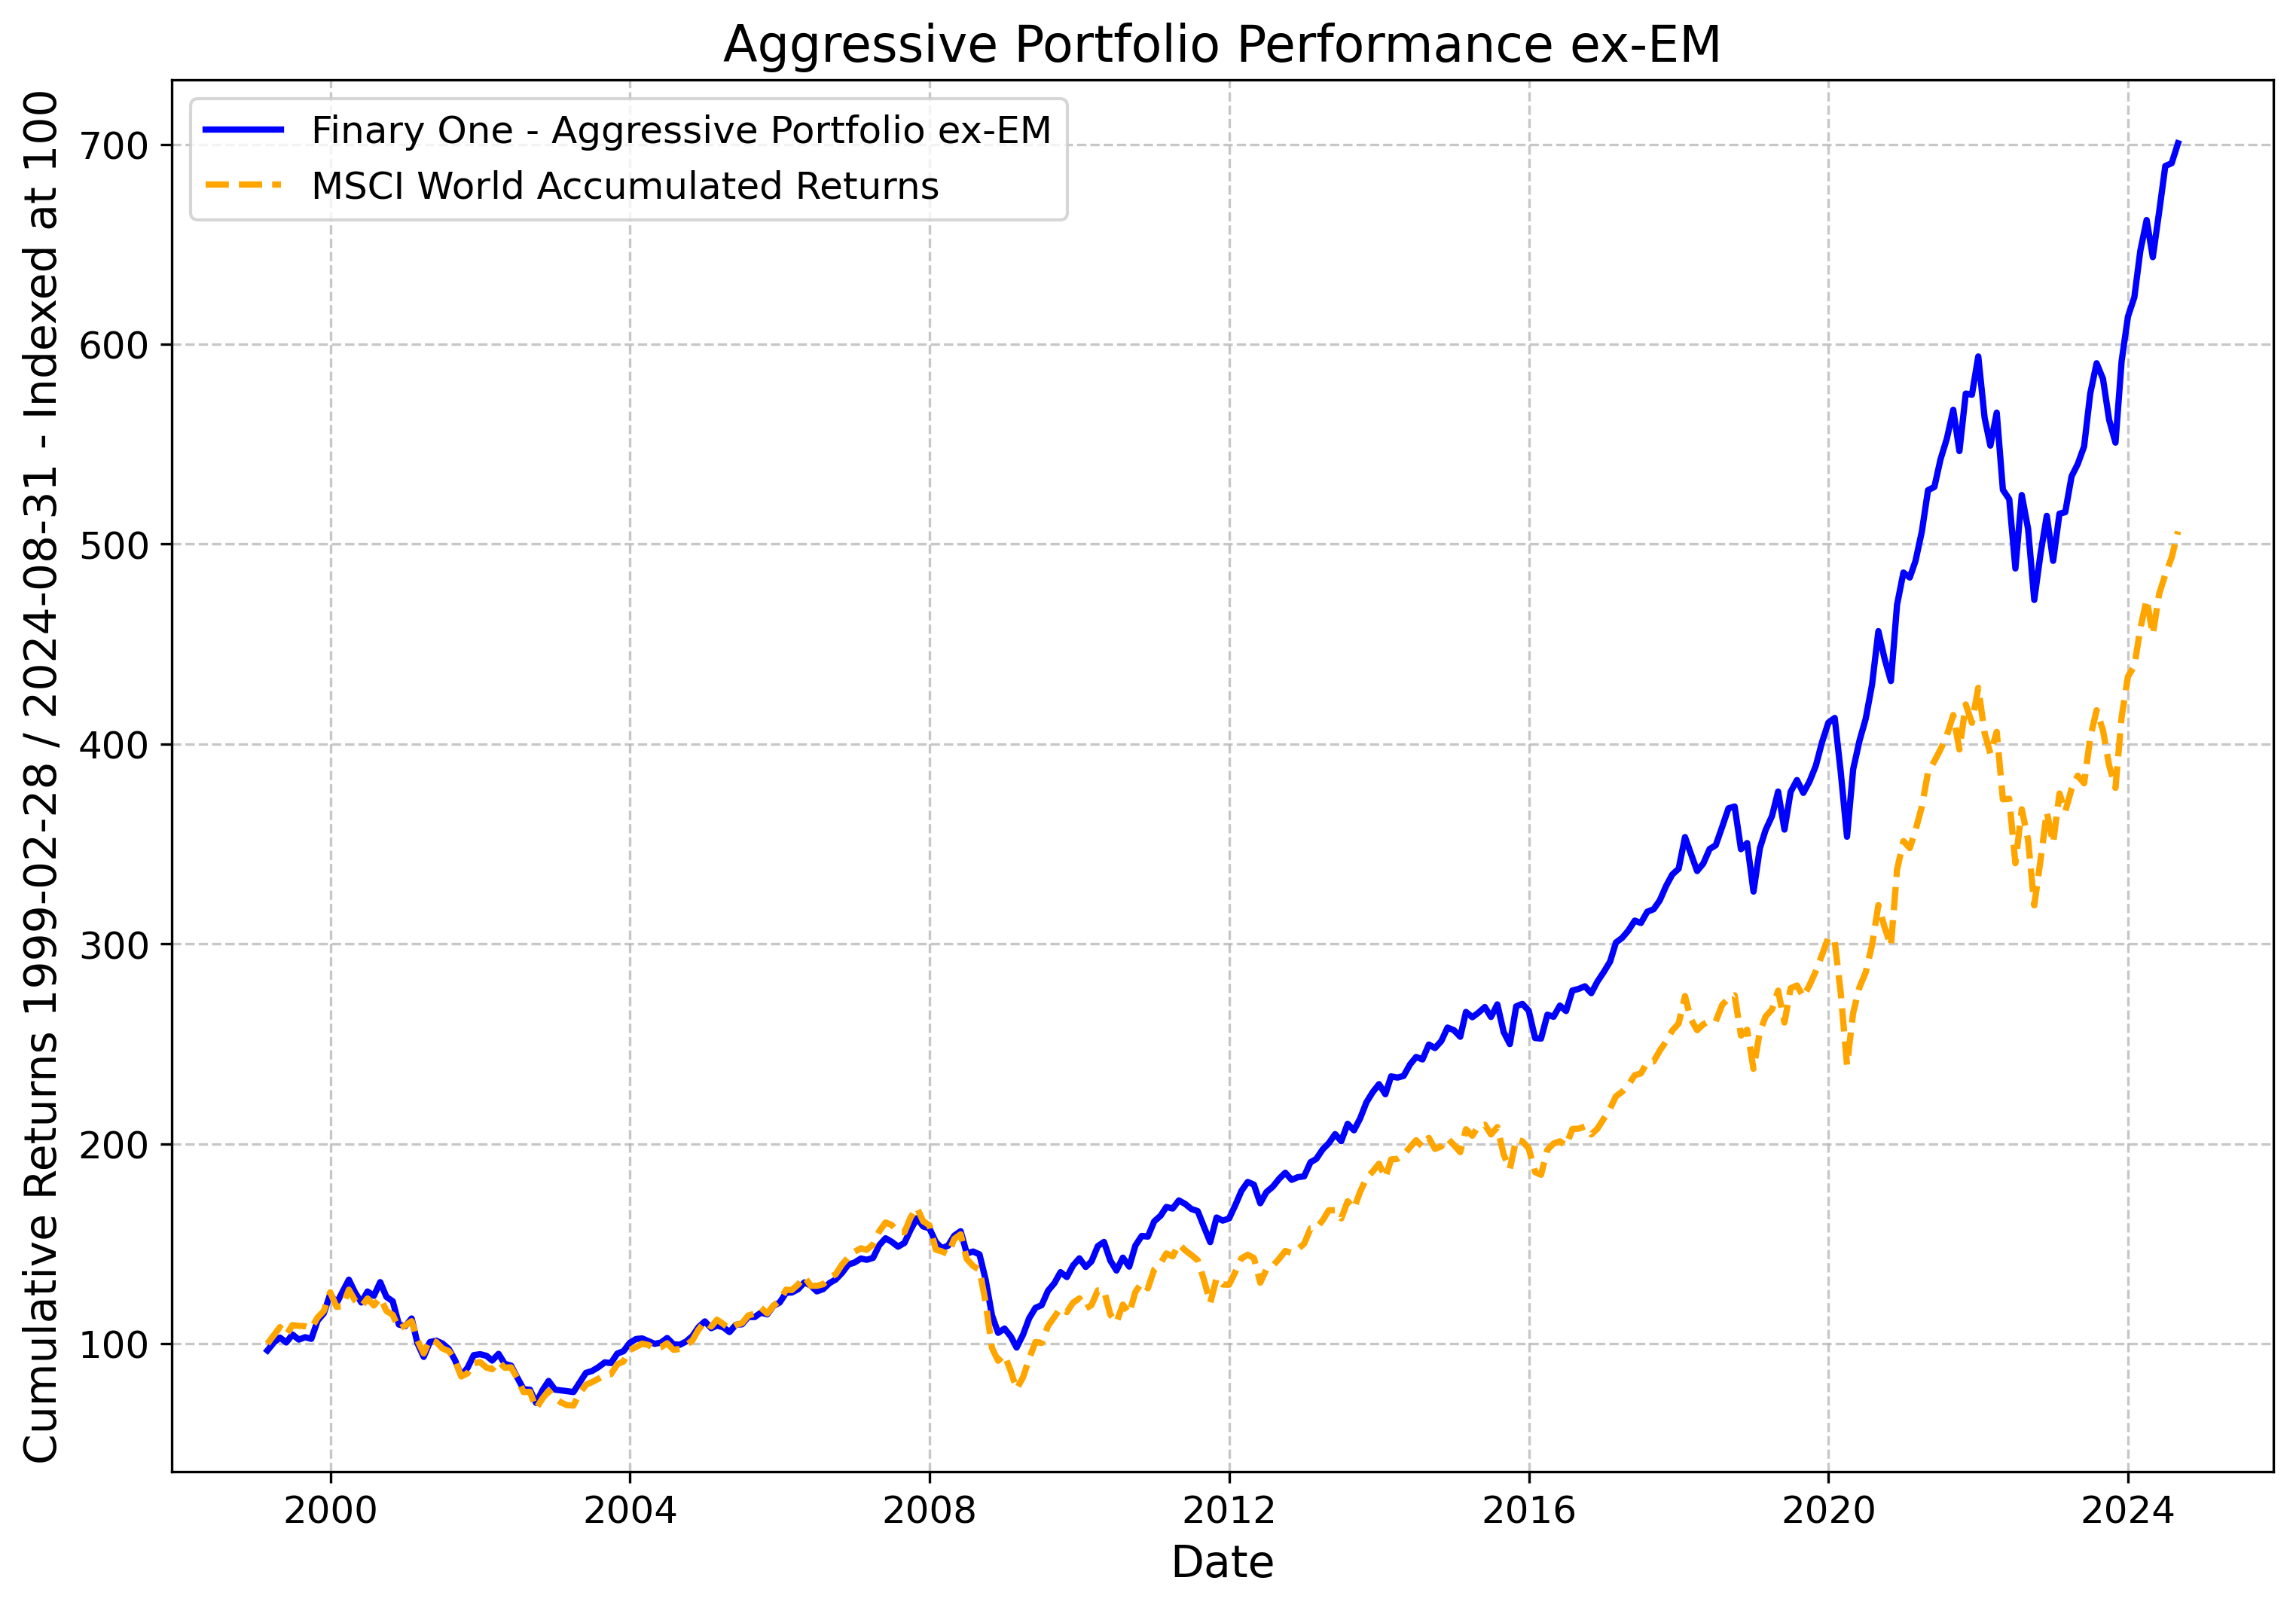

In [15]:
# Step 5: Define your portfolio weights
weights2 = [0.5, 0.2, 0, 0.1, 0.2]

# Ensure weights sum to 1 (optional if weights are already normalized)
weights = [w / sum(weights2) for w in weights2]

# Step 6: Compute the portfolio returns
portfolio_returns2 = returns_df.dot(weights2)

# Step 7: Index cumulative returns to 100 instead of 1
cumulative_returns_indexed2 = 100 * (1 + portfolio_returns2).cumprod()
msci_world_cumulative_returns_indexed = 100 * msci_world_cumulative_returns / msci_world_cumulative_returns.iloc[0]

# Step 8: Save everything in a variable called aggressive_portfolio
cumulative_returns_indexed2.index = pd.to_datetime(cumulative_returns_indexed2.index)

aggressive_portfolio2 = pd.DataFrame({
    'Portfolio_Returns': portfolio_returns,
    'Cumulative_Returns': cumulative_returns_indexed2
})

# Step 9: Plot the performance, indexed at 100
plt.figure(figsize=(12, 8), dpi=300)
plt.plot(cumulative_returns_indexed2, label='Finary One - Aggressive Portfolio ex-EM', color='blue', linewidth=2)
plt.plot(msci_world_cumulative_returns_indexed, label='MSCI World Accumulated Returns', color='orange', linestyle='--', linewidth=2)
plt.title('Aggressive Portfolio Performance ex-EM', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns 1999-02-28 / 2024-08-31 - Indexed at 100', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [16]:
global_stats2 = ffn.calc_stats(cumulative_returns_indexed2)
global_stats2.set_riskfree_rate(0.005)
global_stats2.display()

Stats for None from 1999-02-28 00:00:00 - 2024-08-31 00:00:00
Annual risk-free rate considered: 0.50%
Summary:
Total Return    Sharpe    CAGR    Max Drawdown
--------------  --------  ------  --------------
625.03%         -         8.08%   -46.70%

Annualized Returns:
mtd    3m     6m     ytd     1y      3y     5y      10y     incep.
-----  -----  -----  ------  ------  -----  ------  ------  --------
1.45%  5.15%  8.34%  14.11%  20.22%  7.29%  13.27%  10.87%  8.08%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  -        0.63       0.48
mean    -        8.64%      8.49%
vol     -        13.00%     16.60%
skew    -        -0.56      -0.79
kurt    -        0.69       0.06
best    -        9.55%      32.64%
worst   -        -13.54%    -31.77%

Drawdowns:
max      avg       # days
-------  ------  --------
-46.70%  -6.17%     185.2

Misc:
---------------  ------
avg. up month    3.00%
avg. down month  -3.07%
up year %        76.00%
12m up %     

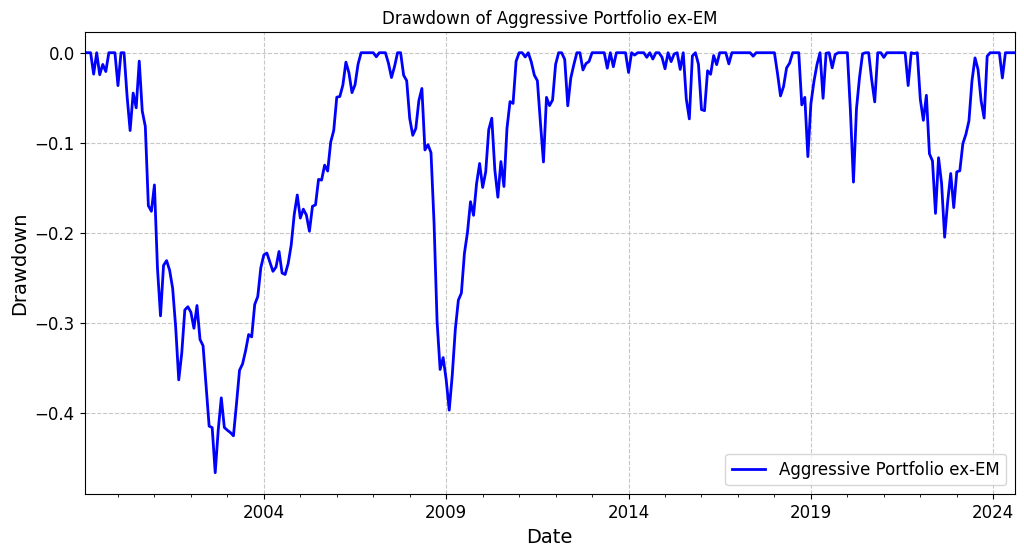

In [17]:
# Plot the drawdown series for the aggressive portfolio
drawdown2 = global_stats2.prices.to_drawdown_series().plot(
    figsize=(12, 6),
    grid=True, 
    title='Drawdown of Aggressive Portfolio ex-EM', 
    color='blue', 
    linewidth=2,
)

# Add labels and legend
plt.xlabel('Date', fontsize=14)
plt.ylabel('Drawdown', fontsize=14)
plt.legend(['Aggressive Portfolio ex-EM'], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

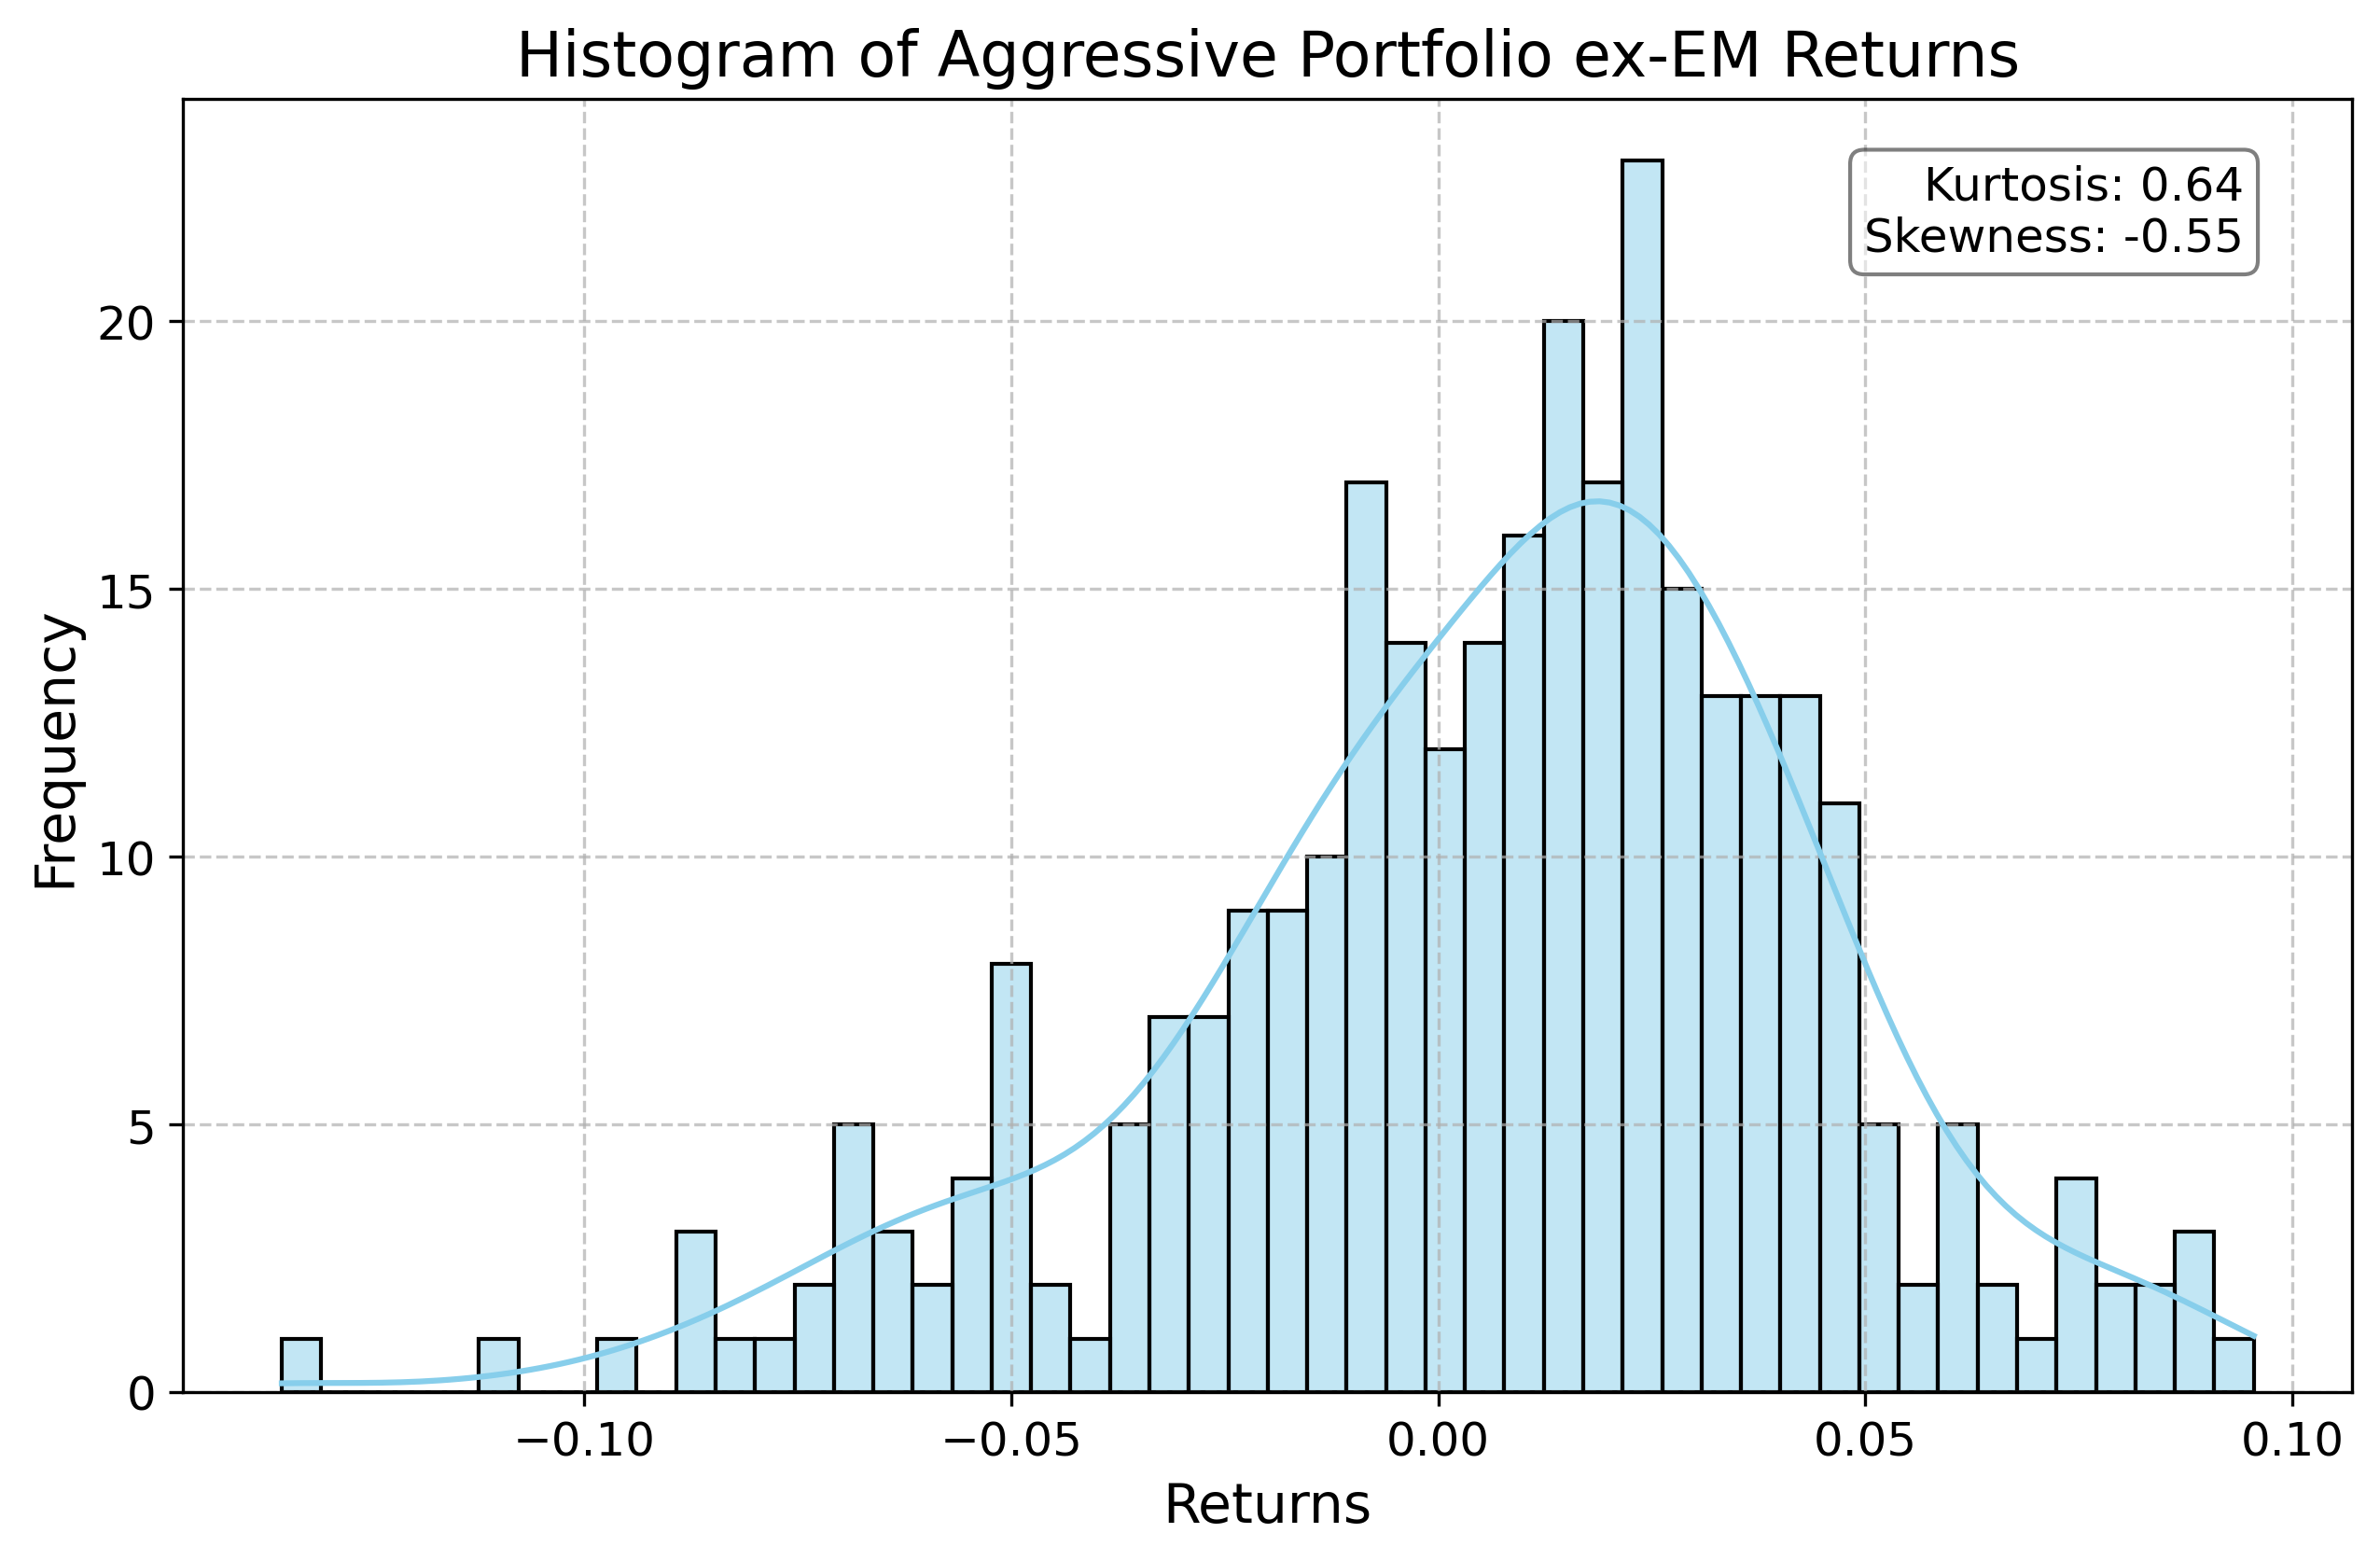

In [18]:
# Plot the histogram
plt.figure(figsize=(10, 6),  dpi=300)
sns.histplot(portfolio_returns2, bins=50, kde=True, color='skyblue', edgecolor='black')

# Calculate kurtosis and skewness
kurt = kurtosis(portfolio_returns2)
skewness = skew(portfolio_returns2)

# Add text box with kurtosis and skewness
textstr = f'Kurtosis: {kurt:.2f}\nSkewness: {skewness:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.gca().text(0.95, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', horizontalalignment='right', bbox=props)

# Add labels and title
plt.title('Histogram of Aggressive Portfolio ex-EM Returns', fontsize=16)
plt.xlabel('Returns', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**END OF FILE**